# In this code I wanna merge the Direct and Indirect Delivery and Plot it 

In [1]:
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
# geopandas 
from shapely.geometry import Point
import geopandas as gpd

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

In [2]:
# Inputs
InDirect_dir = '/home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/2023'
Direct_dir = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats'


categories = ['avg', 'high', 'low', 'surge']
year = 23
# outputs
out_dir_fig = '/home/abolmaal/modelling/FVCOM/Huron/Figures'
out_dir = '/home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/new'

# merge Direct and InDirect loads and estimate total load 

In [ ]:
import os
import pandas as pd

def merge_direct_indirect_loads(category, direct_dir, indirect_dir, out_dir, year="23"):
    direct_file = os.path.join(direct_dir, f'DirectTNTP_CoastalWatershed_{category}_new.csv')
    indirect_file = os.path.join(indirect_dir, f'Indirect_CW_{category}_{year}.csv')

    if not os.path.exists(indirect_file):
        raise FileNotFoundError(f"❌ Indirect file not found: {indirect_file}")
    if not os.path.exists(direct_file):
        raise FileNotFoundError(f"❌ Direct file not found: {direct_file}")

    direct_df = pd.read_csv(direct_file)
    indirect_df = pd.read_csv(indirect_file)

    # Rename CW_Area to avoid conflicts
    direct_df.rename(columns={'CW_Area': 'CW_Area_direct'}, inplace=True)
    indirect_df.rename(columns={'CW_Area': 'CW_Area_indirect'}, inplace=True)

    # Merge on CW_Id
    merged_df = pd.merge(
        direct_df,
        indirect_df,
        on='CW_Id',
        how='outer',
        suffixes=('_direct', '_indirect')
    )

    # Total nutrient loads
    merged_df[f'TotalN_{category}_grm2yr'] = (
        merged_df['TotalIndirectCW_TN_grm2yr'] +
        merged_df[f'CoastalWatershedDirectTN_{category}_grm2yr']
    )
    merged_df[f'TotalP_{category}_grm2yr'] = (
        merged_df['TotalIndirectCW_TP_grm2yr'] +
        merged_df[f'CoastalWatershedDirectTP_{category}_grm2yr']
    )

    # Select and reorder columns
    selected_columns = [
        'CW_Id',
        'start_lat',
        'start_lon',
        f'CoastalWatershedDirectTN_{category}_grm2yr',
        f'CoastalWatershedDirectTP_{category}_grm2yr',
        'TotalIndirectCW_TN_grm2yr',
        'TotalIndirectCW_TP_grm2yr',
        f'TotalN_{category}_grm2yr',
        f'TotalP_{category}_grm2yr',
        'Wetland',
        'group_ids',
        'particle_ids',
    ]
    merged_df = merged_df[selected_columns]

    # Save to CSV
    output_file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{category}_{year}.csv')
    merged_df.to_csv(output_file, index=False)

    return merged_df


In [5]:
import os
import pandas as pd
import numpy as np

def merge_direct_indirect_loads(category, direct_dir, indirect_dir, out_dir, year="23"):
    direct_file = os.path.join(direct_dir, f"DirectTNTP_CoastalWatershed_{category}_new.csv")
    indirect_file = os.path.join(indirect_dir, f"Indirect_CW_{category}_{year}.csv")

    if not os.path.exists(indirect_file):
        raise FileNotFoundError(f"Indirect file not found: {indirect_file}")
    if not os.path.exists(direct_file):
        raise FileNotFoundError(f"Direct file not found: {direct_file}")

    direct_df = pd.read_csv(direct_file)
    indirect_df = pd.read_csv(indirect_file)

    # Optional: make sure CW_Id is treated consistently
    # (uncomment if you suspect dtype mismatch)
    # direct_df["CW_Id"] = direct_df["CW_Id"].astype(int)
    # indirect_df["CW_Id"] = indirect_df["CW_Id"].astype(int)

    # Rename CW_Area to avoid conflicts (even if we don't keep them in final output)
    if "CW_Area" in direct_df.columns:
        direct_df = direct_df.rename(columns={"CW_Area": "CW_Area_direct"})
    if "CW_Area" in indirect_df.columns:
        indirect_df = indirect_df.rename(columns={"CW_Area": "CW_Area_indirect"})

    # --- Merge on CW_Id ---
    merged_df = pd.merge(
        direct_df,
        indirect_df,
        on="CW_Id",
        how="outer",            # outer so you can see CW_Ids only in one side
        suffixes=("_direct", "_indirect"),
        indicator=True          # tells you where rows came from
    )

    # Optional: quick diagnostics on mismatched CW_Id
    only_direct = merged_df[merged_df["_merge"] == "left_only"]["CW_Id"].unique()
    only_indirect = merged_df[merged_df["_merge"] == "right_only"]["CW_Id"].unique()
    both = merged_df[merged_df["_merge"] == "both"]["CW_Id"].unique()

    print(f"CW_Id only in direct:   {len(only_direct)}")
    print(f"CW_Id only in indirect: {len(only_indirect)}")
    print(f"CW_Id in both:          {len(both)}")

    # If you want to drop ids that are ONLY indirect, keep only left + both:
    merged_df = merged_df[merged_df["_merge"] != "right_only"].copy()

    # Drop merge indicator now that we're done with it
    merged_df = merged_df.drop(columns=["_merge"])

    # --- Total nutrient loads ---
    tn_direct_col = f"CoastalWatershedDirectTN_{category}_grm2yr"
    tp_direct_col = f"CoastalWatershedDirectTP_{category}_grm2yr"
    tn_indirect_col = "TotalIndirectCW_TN_grm2yr"
    tp_indirect_col = "TotalIndirectCW_TP_grm2yr"

    # Fill NaN only for numeric load columns, not all columns
    for col in [tn_direct_col, tp_direct_col, tn_indirect_col, tp_indirect_col]:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].fillna(0.0)

    merged_df[f"TotalN_{category}_grm2yr"] = (
        merged_df.get(tn_direct_col, 0) + merged_df.get(tn_indirect_col, 0)
    )
    merged_df[f"TotalP_{category}_grm2yr"] = (
        merged_df.get(tp_direct_col, 0) + merged_df.get(tp_indirect_col, 0)
    )

    # --- Select and reorder columns (only keep what actually exists) ---
    desired_columns = [
        "CW_Id",
        "start_lat",
        "start_lon",
        tn_direct_col,
        tp_direct_col,
        tn_indirect_col,
        tp_indirect_col,
        f"TotalN_{category}_grm2yr",
        f"TotalP_{category}_grm2yr",
        "Wetland",
        "group_ids",
        "particle_ids",
    ]

    existing_columns = [c for c in desired_columns if c in merged_df.columns]
    merged_df = merged_df[existing_columns]

    # --- Save to CSV ---
    os.makedirs(out_dir, exist_ok=True)
    output_file = os.path.join(out_dir, f"Total_Direct_Indirect_Loads_{category}_{year}.csv")
    merged_df.to_csv(output_file, index=False)

    print(f"Saved merged direct+indirect loads to: {output_file}")
    return merged_df


# merge Direct and InDirect loads and estimate total load  for different Indirect tracking 

In [6]:
release_lens = ["first1days", "first5days", "first10days", "first26days", "first60days", "first90days"]

def merge_direct_indirect_loads(category, direct_dir, indirect_dir, out_dir, year="23", release_lens=release_lens):
    results = {}

    direct_file = os.path.join(direct_dir, f'DirectTNTP_CoastalWatershed_{category}.csv')
    if not os.path.exists(direct_file):
        raise FileNotFoundError(f"❌ Direct file not found: {direct_file}")

    direct_df = pd.read_csv(direct_file)
    direct_df.rename(columns={'CW_Area': 'CW_Area_direct'}, inplace=True)

    for rlen in release_lens:
        indirect_file = os.path.join(indirect_dir, f'Indirect_CW_{category}_{year}_{rlen}.csv')
        if not os.path.exists(indirect_file):
            print(f"⚠️ Indirect file not found: {indirect_file}, skipping...")
            continue

        indirect_df = pd.read_csv(indirect_file)
        indirect_df.rename(columns={'CW_Area': 'CW_Area_indirect'}, inplace=True)

        merged_df = pd.merge(
            direct_df,
            indirect_df,
            on='CW_Id',
            how='left',
            suffixes=('_direct', '_indirect')
        ).fillna(0)

        merged_df[f'TotalN_{category}_{rlen}_grm2yr'] = (
            merged_df['TotalIndirectCW_TN_grm2yr'] +
            merged_df[f'CoastalWatershedDirectTN_{category}_grm2yr']
        )
        merged_df[f'TotalP_{category}_{rlen}_grm2yr'] = (
            merged_df['TotalIndirectCW_TP_grm2yr'] +
            merged_df[f'CoastalWatershedDirectTP_{category}_grm2yr']
        )

        output_file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{category}_{year}_{rlen}.csv')
        merged_df.to_csv(output_file, index=False)
        results[rlen] = merged_df

    return results


In [6]:
# estimate the total N & P for each coastal wetland by merging the direct and indirect loads and summing them
merged_results = {}

for cat in categories:
    merged_results[cat] = merge_direct_indirect_loads(cat, Direct_dir, InDirect_dir, out_dir)

CW_Id only in direct:   822
CW_Id only in indirect: 1380
CW_Id in both:          226
Saved merged direct+indirect loads to: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/new/Total_Direct_Indirect_Loads_avg_23.csv
CW_Id only in direct:   1878
CW_Id only in indirect: 1546
CW_Id in both:          315
Saved merged direct+indirect loads to: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/new/Total_Direct_Indirect_Loads_high_23.csv
CW_Id only in direct:   459
CW_Id only in indirect: 1058
CW_Id in both:          205
Saved merged direct+indirect loads to: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/new/Total_Direct_Indirect_Loads_low_23.csv
CW_Id only in direct:   2798
CW_Id only in indirect: 1672
CW_Id in both:          355
Saved merged direct+indirect loads to: /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/new/Total_Direct_Indirect_Loads_surge_23.csv


In [8]:
# show the columns that are zero in merged_results['avg']
zero_columns = merged_results['avg'].columns[merged_results['avg'].eq(0).any()]
print("Columns with zero values in merged_results['avg']:", zero_columns.tolist())

Columns with zero values in merged_results['avg']: ['start_lat', 'start_lon', 'TotalIndirectCW_TN_grm2yr', 'TotalIndirectCW_TP_grm2yr', 'Wetland', 'group_ids', 'particle_ids']


In [7]:
# show the results for avg category
merged_results['avg'].columns

Index(['CW_Id', 'start_lat', 'start_lon',
       'CoastalWatershedDirectTN_avg_grm2yr',
       'CoastalWatershedDirectTP_avg_grm2yr', 'TotalIndirectCW_TN_grm2yr',
       'TotalIndirectCW_TP_grm2yr', 'TotalN_avg_grm2yr', 'TotalP_avg_grm2yr',
       'Wetland', 'group_ids', 'particle_ids'],
      dtype='object')

In [8]:
# For TN
tn_col = 'CoastalWatershedDirectTN_avg_grm2yr'
ind_tn_min_idx = merged_results['avg'][tn_col].idxmin()
ind_tn_max_idx = merged_results['avg'][tn_col].idxmax()

print("TotalIndirectCW_TN_grm2yr - Min:",
      merged_results['avg'].loc[ind_tn_min_idx, tn_col],
      "CW_Id:", merged_results['avg'].loc[ind_tn_min_idx, 'CW_Id'],
      "| Max:",
      merged_results['avg'].loc[ind_tn_max_idx, tn_col],
      "CW_Id:", merged_results['avg'].loc[ind_tn_max_idx, 'CW_Id'])

# For TP
tp_col = 'CoastalWatershedDirectTP_avg_grm2yr'
tp_min_idx = merged_results['avg'][tp_col].idxmin()
tp_max_idx = merged_results['avg'][tp_col].idxmax()

print("CoastalWatershedDirectTP_avg_grm2yr - Min:",
      merged_results['avg'].loc[tp_min_idx, tp_col],
      "CW_Id:", merged_results['avg'].loc[tp_min_idx, 'CW_Id'],
      "| Max:",
      merged_results['avg'].loc[tp_max_idx, tp_col],
      "CW_Id:", merged_results['avg'].loc[tp_max_idx, 'CW_Id'])

TotalIndirectCW_TN_grm2yr - Min: 0.0001053742153417 CW_Id: 625 | Max: 3.755365213107192 CW_Id: 2799
CoastalWatershedDirectTP_avg_grm2yr - Min: 0.0001053742153417 CW_Id: 625 | Max: 3.755365213107192 CW_Id: 2799


In [10]:
# --- Indirect TN ---
ind_tn_col = 'TotalIndirectCW_TN_grm2yr'
ind_tn_min_idx = merged_results['avg'][ind_tn_col].idxmin()
ind_tn_max_idx = merged_results['avg'][ind_tn_col].idxmax()

print("TotalIndirectCW_TN_grm2yr - Min:",
      merged_results['avg'].loc[ind_tn_min_idx, ind_tn_col],
      "CW_Id:", merged_results['avg'].loc[ind_tn_min_idx, 'CW_Id'],
      "| Max:",
      merged_results['avg'].loc[ind_tn_max_idx, ind_tn_col],
      "CW_Id:", merged_results['avg'].loc[ind_tn_max_idx, 'CW_Id'])

# --- Indirect TP ---
ind_tp_col = 'TotalIndirectCW_TP_grm2yr'
ind_tp_min_idx = merged_results['avg'][ind_tp_col].idxmin()
ind_tp_max_idx = merged_results['avg'][ind_tp_col].idxmax()

print("TotalIndirectCW_TP_grm2yr - Min:",
      merged_results['avg'].loc[ind_tp_min_idx, ind_tp_col],
      "CW_Id:", merged_results['avg'].loc[ind_tp_min_idx, 'CW_Id'],
      "| Max:",
      merged_results['avg'].loc[ind_tp_max_idx, ind_tp_col],
      "CW_Id:", merged_results['avg'].loc[ind_tp_max_idx, 'CW_Id'])

TotalIndirectCW_TN_grm2yr - Min: 0.0 CW_Id: 14 | Max: 60182.1338596484 CW_Id: 2956
TotalIndirectCW_TP_grm2yr - Min: 0.0 CW_Id: 14 | Max: 2129.9969792554407 CW_Id: 2956


In [11]:
# --- Indirect TN ---
ind_tn_col = 'TotalIndirectCW_TN_grm2yr'

# Min
ind_tn_min_idx = merged_results['avg'][ind_tn_col].idxmin()
print("TotalIndirectCW_TN_grm2yr - Min:",
      merged_results['avg'].loc[ind_tn_min_idx, ind_tn_col],
      "CW_Id:", merged_results['avg'].loc[ind_tn_min_idx, 'CW_Id'])

# Top 3 Max
ind_tn_top3 = merged_results['avg'].nlargest(40, ind_tn_col)[['CW_Id', ind_tn_col]]
print("\nTop 3 Max values for TotalIndirectCW_TN_grm2yr:")
print(ind_tn_top3.to_string(index=False))

# --- Indirect TP ---
ind_tp_col = 'TotalIndirectCW_TP_grm2yr'

# Min
ind_tp_min_idx = merged_results['avg'][ind_tp_col].idxmin()
print("\nTotalIndirectCW_TP_grm2yr - Min:",
      merged_results['avg'].loc[ind_tp_min_idx, ind_tp_col],
      "CW_Id:", merged_results['avg'].loc[ind_tp_min_idx, 'CW_Id'])

# Top 3 Max
ind_tp_top3 = merged_results['avg'].nlargest(20, ind_tp_col)[['CW_Id', ind_tp_col]]
print("\nTop 3 Max values for TotalIndirectCW_TP_grm2yr:")
print(ind_tp_top3.to_string(index=False))


TotalIndirectCW_TN_grm2yr - Min: 0.0 CW_Id: 14

Top 3 Max values for TotalIndirectCW_TN_grm2yr:
 CW_Id  TotalIndirectCW_TN_grm2yr
  2956               60182.133860
  3131               43936.083350
  2319               39928.781925
   685               37874.090986
   214               28275.537133
  6027               21130.417106
  1728               18710.741833
  1953               18381.523636
  2227               17437.574248
  1521               17335.549780
  2081               16663.122083
  2020               13786.487049
  4795               13709.940095
  1315               13002.778743
   219               12567.611561
  1162               12135.201446
  2088               10569.997203
   549               10474.919372
  1323               10112.172993
  3535                9919.820983
   542                9660.669650
  5892                8389.329753
  2067                8315.072864
  1942                7948.728812
  1625                7138.032098
  2963              

# Merge with different Indirect time period tracking 

In [ ]:
Intersection_summary_10 = 'Intersection_summary_avg_10days.csv'
Intersection_summary_5 = 'Intersection_summary_avg_5days.csv'
Intersection_summary_26 = 'Intersection_summary_avg_26days.csv'
Intersection_summary_35 = 'Intersection_summary_avg_35days.csv'
Intersection_summary_60 = 'Intersection_summary_avg_60days.csv'

In [16]:
def merge_direct_indirect_loads(category, direct_dir, indirect_dir, out_dir, year="23",
                                days_list=[ "first5days", "first10days",
                                           "first26days", "first35days","first60days", "first90days"]):
    """
    Merge Direct and Indirect loads for multiple day-limit horizons separately.

    Parameters
    ----------
    category : str
        CW category (e.g., 'avg', 'low', 'high', 'surge')
    direct_dir : str
        Directory with direct load CSV
    indirect_dir : str
        Directory with indirect load CSVs
    out_dir : str
        Directory to save merged outputs
    year : str
        Year string (default '23')
    days_list : list of str
        Horizons like ["first1days","first5days",...]
    """
    # Direct file (same for all horizons)
    direct_file = os.path.join(direct_dir, f'DirectTNTP_CoastalWatershed_{category}.csv')
    if not os.path.exists(direct_file):
        raise FileNotFoundError(f"❌ Direct file not found: {direct_file}")
    direct_df = pd.read_csv(direct_file)
    direct_df.rename(columns={'CW_Area': 'CW_Area_direct'}, inplace=True)

    results = {}

    for d in days_list:
        indirect_file = os.path.join(indirect_dir, f'Indirect_CW_{category}_{year}_{d}.csv')
        if not os.path.exists(indirect_file):
            print(f"⚠️ Indirect file not found: {indirect_file}")
            continue

        indirect_df = pd.read_csv(indirect_file)
        indirect_df.rename(columns={'CW_Area': 'CW_Area_indirect'}, inplace=True)

        # Merge on CW_Id
        merged_df = pd.merge(
            direct_df,
            indirect_df,
            on='CW_Id',
            how='left',
            suffixes=('_direct', '_indirect')
        ).fillna(0)

        # Compute totals
        merged_df[f'TotalN_{category}_{d}_grm2yr'] = (
            merged_df['TotalIndirectCW_TN_grm2yr'] +
            merged_df[f'CoastalWatershedDirectTN_{category}_grm2yr']
        )
        merged_df[f'TotalP_{category}_{d}_grm2yr'] = (
            merged_df['TotalIndirectCW_TP_grm2yr'] +
            merged_df[f'CoastalWatershedDirectTP_{category}_grm2yr']
        )

        # Select & reorder columns
        selected_columns = [
            'CW_Id',
            'start_lat',
            'start_lon',
            f'CoastalWatershedDirectTN_{category}_grm2yr',
            f'CoastalWatershedDirectTP_{category}_grm2yr',
            'TotalIndirectCW_TN_grm2yr',
            'TotalIndirectCW_TP_grm2yr',
            f'TotalN_{category}_{d}_grm2yr',
            f'TotalP_{category}_{d}_grm2yr',
            'Wetland',
            'group_ids',
            'particle_ids',
        ]
        merged_df = merged_df[selected_columns]

        # Save per horizon
        output_file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{category}_{year}_{d}.csv')
        merged_df.to_csv(output_file, index=False)

        print(f"✅ Merged saved → {output_file}")
        results[d] = merged_df

    return results


In [17]:
# estimate the total N & P for each coastal wetland by merging the direct and indirect loads and summing them
merged_results = {}

for cat in categories:
    merged_results[cat] = merge_direct_indirect_loads(cat, Direct_dir, InDirect_dir, out_dir)

✅ Merged saved → /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/Total_Direct_Indirect_Loads_avg_23_first5days.csv
✅ Merged saved → /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/Total_Direct_Indirect_Loads_avg_23_first10days.csv
✅ Merged saved → /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/Total_Direct_Indirect_Loads_avg_23_first26days.csv
✅ Merged saved → /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/Total_Direct_Indirect_Loads_avg_23_first35days.csv
✅ Merged saved → /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/Total_Direct_Indirect_Loads_avg_23_first60days.csv
✅ Merged saved → /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/Total_Direct_Indirect_Loads_avg_23_first90days.csv
✅ Merged saved → /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/Total_Direct_Indirect_Loads_high_23_first5days.csv
✅ Merged saved → /home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/Total_Direct_Indirect_Loads_high_23_first10days.csv
✅ Merged saved → /home/abolmaal/modelling/FVCOM/Huron/To

# Read the results 

In [12]:
# read all the category of the merged results
# Loop and read each file into its own named variable like Total_avg_23, Total_high_23, etc.
for cat in categories:
    file_path = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{cat}_{year}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Category'] = cat  # Optional: tag the category inside the DataFrame
        var_name = f"Total_{cat}_{year}"
        globals()[var_name] = df  # Creates variable like Total_avg_23
        print(f"✅ Loaded: {var_name}")
    else:
        print(f"❌ File not found: {file_path}")


✅ Loaded: Total_avg_23
✅ Loaded: Total_high_23
✅ Loaded: Total_low_23
✅ Loaded: Total_surge_23


In [13]:
# print the unique values in Wetland column 
print(Total_avg_23['Wetland'].unique())

# couunt the occurance of each unique value in Wetland column
wetland_counts = Total_avg_23['Wetland'].value_counts()
print(wetland_counts)


[nan]
Series([], Name: count, dtype: int64)


In [19]:

def plot_log_boxplot_grouped(df, nutrient_col, wetland_col, output_dir=".", title=None):
    d = df[[nutrient_col, wetland_col]].copy()

    # Keep only valid positive values
    d = d[np.isfinite(d[nutrient_col]) & (d[nutrient_col] > 0)]
    d = d[(d[wetland_col] != 0) & (d[wetland_col] != '0')]

    # Group wetland types
    group_map = {
        'Shrub Peatland': 'Shrub/Forested/Peatland',
        'Shrub Wetland': 'Shrub/Forested/Peatland',
        'Forested Wetland': 'Shrub/Forested/Peatland',
    }
    d['wetland_group'] = d[wetland_col].replace(group_map)
    d = d[d['wetland_group'].notna()]
    d['log_val'] = np.log10(d[nutrient_col])
    order = d['wetland_group'].value_counts().index.tolist()

    # Create plot
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=d, x='wetland_group', y='log_val', color="lightblue", linecolor="black", order=order, showfliers=True)

    # Set text sizes
    title_text = title or f'Boxplot of log₁₀({nutrient_col}) by {wetland_col} (Grouped)'
    ax.set_title(title_text, fontsize=16)
    ax.set_xlabel(wetland_col, fontsize=14)
    ax.set_ylabel(f'log₁₀({nutrient_col})', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save figure
    safe_title = title.replace(" ", "_") if title else nutrient_col
    filename = f"boxplot_{safe_title}_{year}_{category}.jpeg"
    filepath = os.path.join(output_dir, filename)
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {filepath}")


NameError: name 'category' is not defined

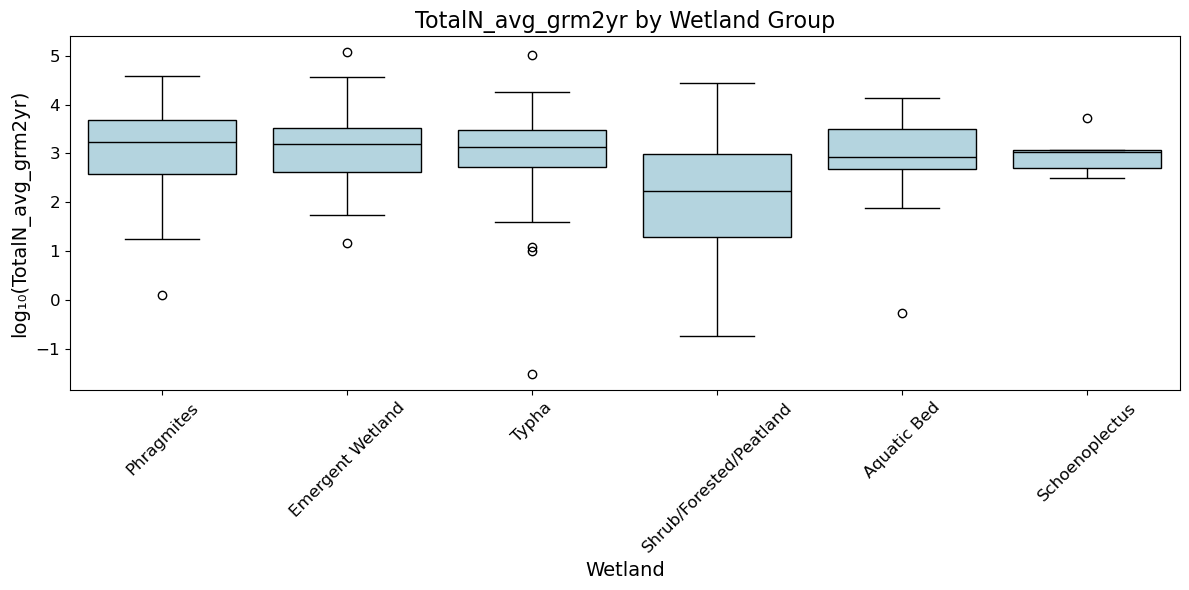

In [20]:
import seaborn as sns
# examples

plot_log_boxplot_grouped(Total_avg_23, 'TotalN_avg_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalN_avg_grm2yr by Wetland Group')
plot_log_boxplot_grouped(Total_avg_23, 'TotalP_avg_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalP_avg_grm2yr by Wetland Group')


✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/boxplot_TotalN_high_grm2yr_by_Wetland_Group_23.jpeg
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/boxplot_TotalP_high_grm2yr_by_Wetland_Group_23.jpeg
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/boxplot_TotalN_low_grm2yr_by_Wetland_Group_23.jpeg
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/boxplot_TotalP_low_grm2yr_by_Wetland_Group_23.jpeg
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/boxplot_TotalN_surge_grm2yr_by_Wetland_Group_23.jpeg
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/boxplot_TotalP_surge_grm2yr_by_Wetland_Group_23.jpeg


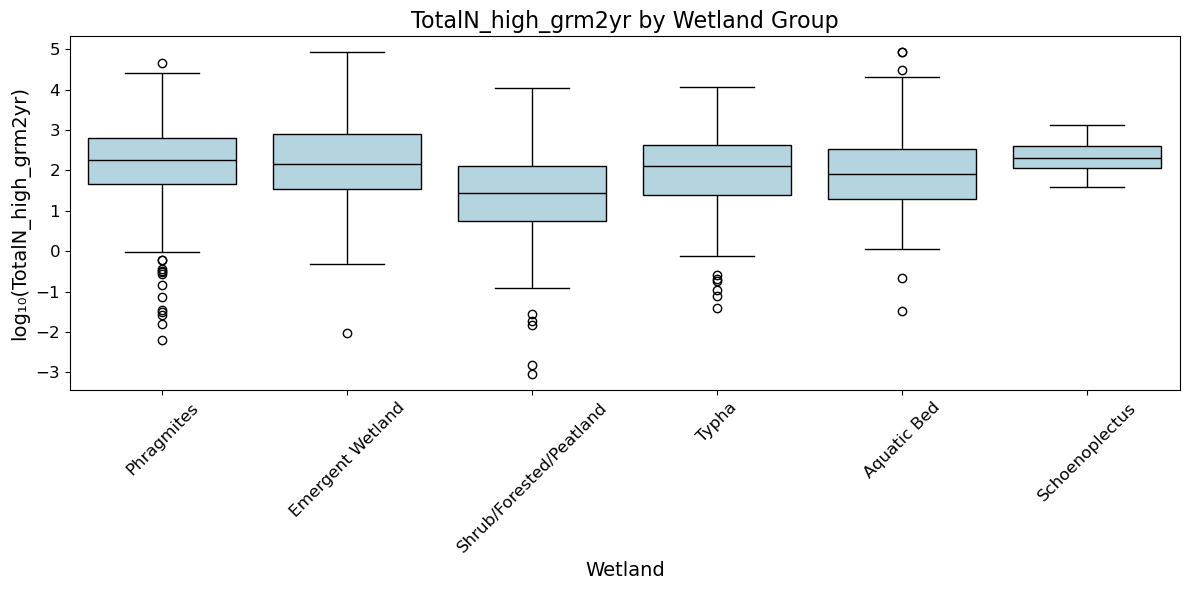

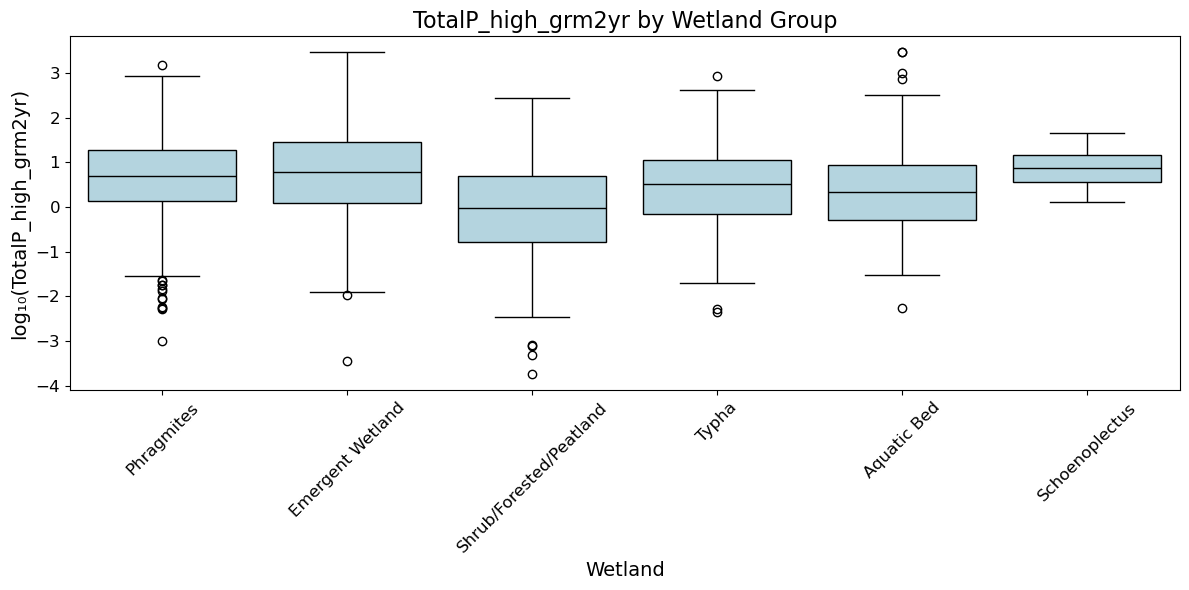

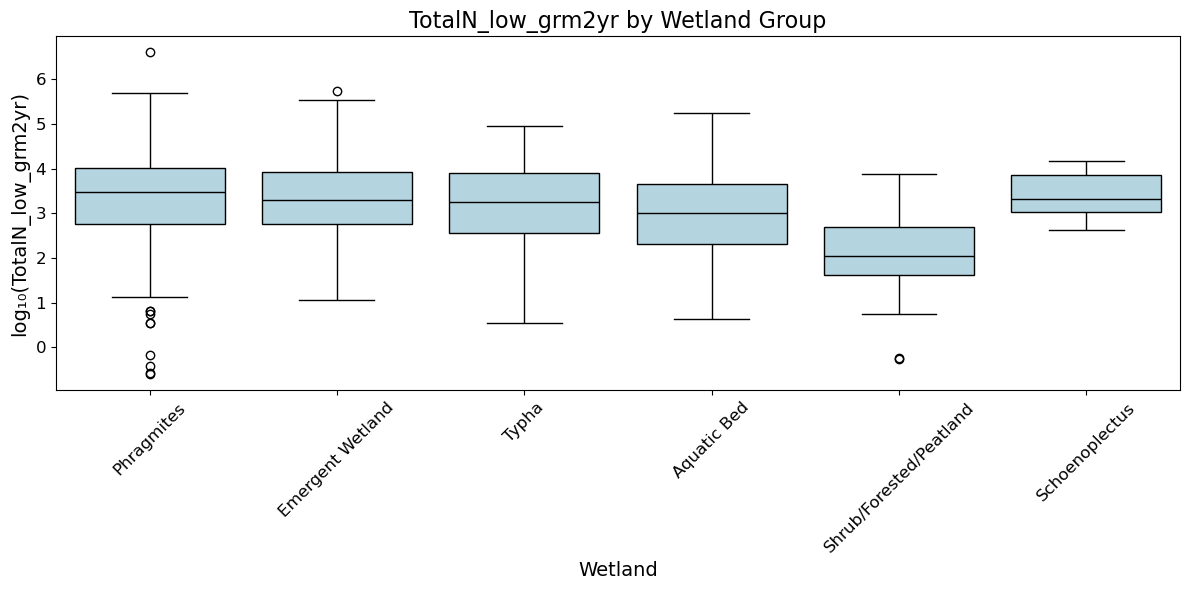

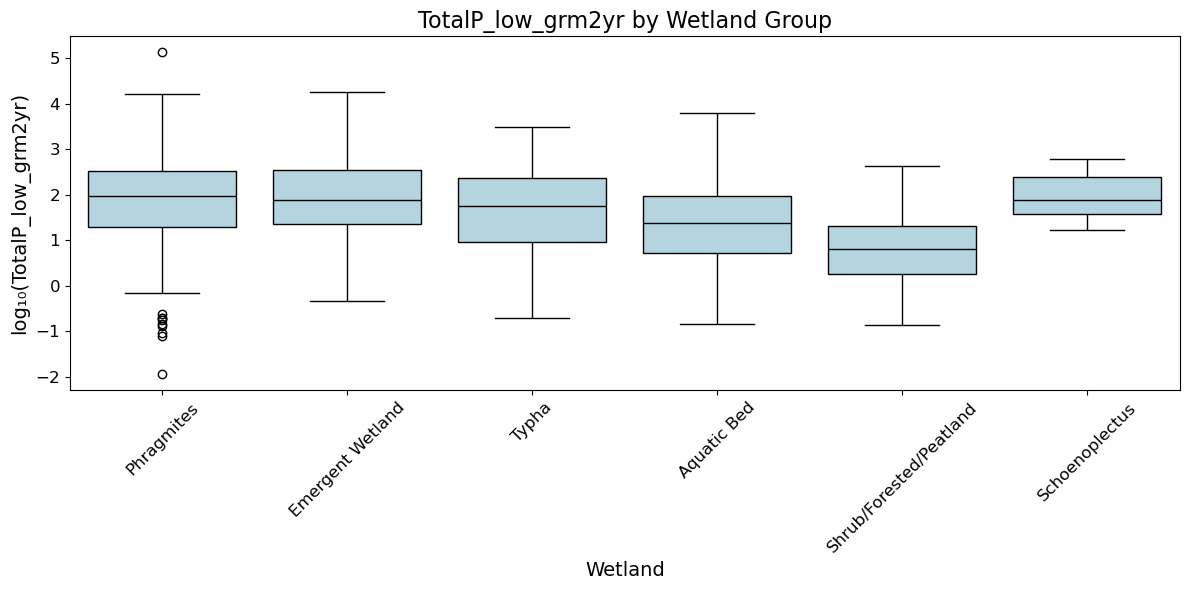

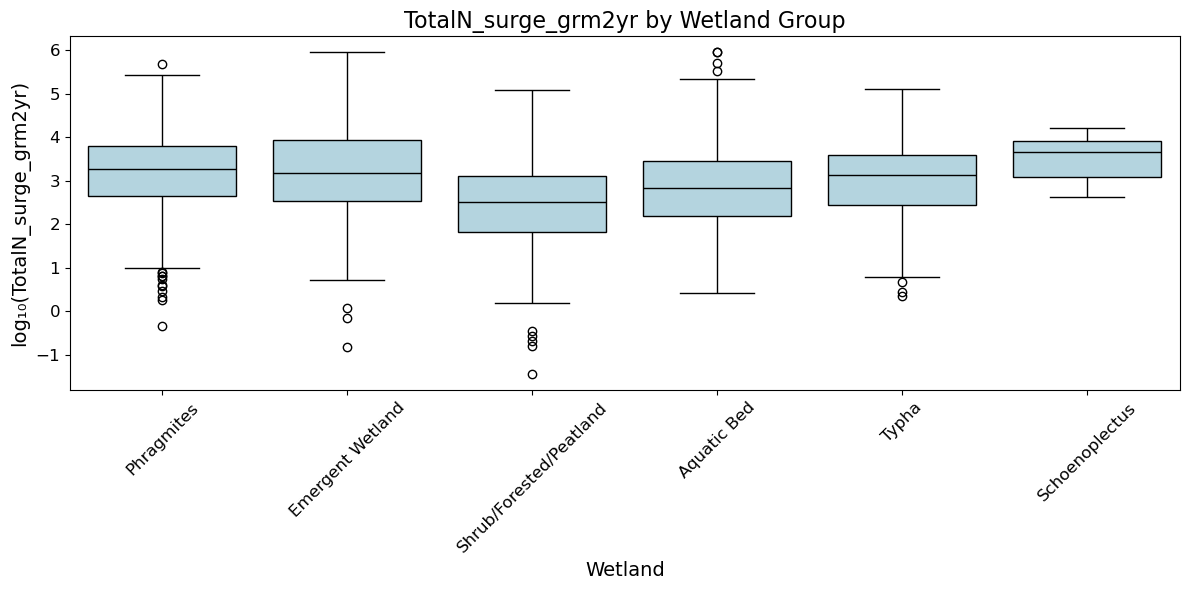

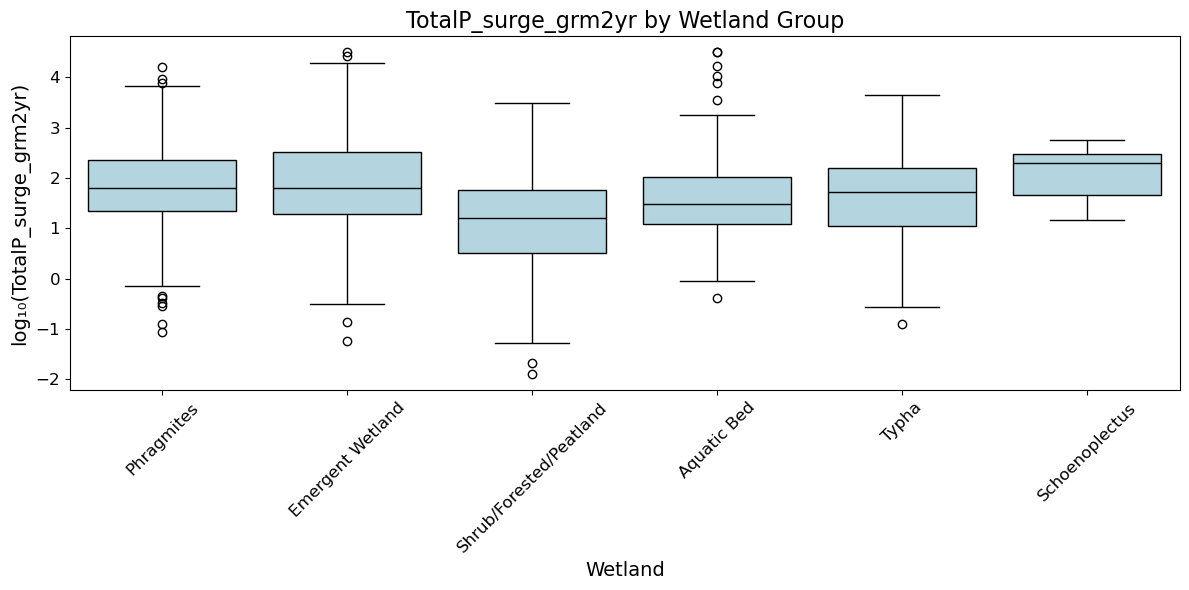

In [29]:
# examples
plot_log_boxplot_grouped(Total_high_23, 'TotalN_high_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalN_high_grm2yr by Wetland Group')
plot_log_boxplot_grouped(Total_high_23, 'TotalP_high_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalP_high_grm2yr by Wetland Group')

# examples
plot_log_boxplot_grouped(Total_low_23, 'TotalN_low_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalN_low_grm2yr by Wetland Group')
plot_log_boxplot_grouped(Total_low_23, 'TotalP_low_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalP_low_grm2yr by Wetland Group')

# examples
plot_log_boxplot_grouped(Total_surge_23, 'TotalN_surge_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalN_surge_grm2yr by Wetland Group')
plot_log_boxplot_grouped(Total_surge_23, 'TotalP_surge_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalP_surge_grm2yr by Wetland Group')



In [11]:
# couunt the occurance of each unique value in Wetland column
wetland_counts = Total_high_23['Wetland'].value_counts()
print(wetland_counts)

Wetland
0                   4653
Phragmites           773
Emergent Wetland     333
Typha                148
Shrub Wetland        126
Aquatic Bed          106
Forested Wetland      36
Schoenoplectus         8
Shrub Peatland         1
Name: count, dtype: int64


In [12]:
# show median max and min of Annual_N and Annual_P
print("Median Total_N:", Total_low_23['TotalN_low_grm2yr'].median())
print("Max Total_N:", Total_low_23['TotalN_low_grm2yr'].max())
print("Min Total_N:", Total_low_23['TotalN_low_grm2yr'].min())
print("median Total_P:", Total_low_23['TotalP_low_grm2yr'].median())
print("Max Total_P:", Total_low_23['TotalP_low_grm2yr'].max())
print("Min Total_P:", Total_low_23['TotalP_low_grm2yr'].min())

Median Total_N: 1.0273727917228823
Max Total_N: 3997955.037561621
Min Total_N: 0.0002145955203289
median Total_P: 1.0273727917228823
Max Total_P: 206078.4169678857
Min Total_P: 0.0002145955203289


In [13]:
# print the median, max and min of IndirectCW_TN_grm2yr and IndirectCW_TP_grm2yr
print("Median IndirectCW_TN_grm2yr:", Total_low_23['TotalIndirectCW_TN_grm2yr'].mean())
print("Max IndirectCW_TN_grm2yr:", Total_low_23['TotalIndirectCW_TN_grm2yr'].max())
print("Min IndirectCW_TN_grm2yr:", Total_low_23['TotalIndirectCW_TN_grm2yr'].min())
print("Median IndirectCW_TP_grm2yr:", Total_low_23['TotalIndirectCW_TP_grm2yr'].mean())
print("Max IndirectCW_TP_grm2yr:", Total_low_23['TotalIndirectCW_TP_grm2yr'].max())
print("Min IndirectCW_TP_grm2yr:", Total_low_23['TotalIndirectCW_TP_grm2yr'].min())


Median IndirectCW_TN_grm2yr: 5918.48644920251
Max IndirectCW_TN_grm2yr: 3997954.9678733214
Min IndirectCW_TN_grm2yr: 0.0
Median IndirectCW_TP_grm2yr: 193.35399472770683
Max IndirectCW_TP_grm2yr: 132135.29581207046
Min IndirectCW_TP_grm2yr: 0.0


In [14]:
# print the min max and median of CoastalWatershedDirectTN_avg_grm2yr and CoastalWatershedDirectTP_avg_grm2yr
print("Median CoastalWatershedDirectTN_avg_grm2yr:", Total_low_23['CoastalWatershedDirectTN_low_grm2yr'].median())
print("Max CoastalWatershedDirectTN_avg_grm2yr:", Total_low_23['CoastalWatershedDirectTN_low_grm2yr'].max())
print("Min CoastalWatershedDirectTN_avg_grm2yr:", Total_low_23['CoastalWatershedDirectTN_low_grm2yr'].min())
# print the 35th, 50th and 75th percentile of CoastalWatershedDirectTP_avg_grm2yr
print("35th percentile CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].quantile(0.35))
print("50th percentile CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].quantile(0.50))
print("75th percentile CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].quantile(0.75))
# print the median, max and min of CoastalWatershedDirectTP_avg_gr

print("Median CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].median())
print("Max CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].max())
print("Min CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].min())

Median CoastalWatershedDirectTN_avg_grm2yr: 0.3426403387549634
Max CoastalWatershedDirectTN_avg_grm2yr: 206078.4169678857
Min CoastalWatershedDirectTN_avg_grm2yr: 0.0001228428388503
35th percentile CoastalWatershedDirectTP_low_grm2yr: 0.1580865395766231
50th percentile CoastalWatershedDirectTP_low_grm2yr: 0.3426403387549634
75th percentile CoastalWatershedDirectTP_low_grm2yr: 1.3691002021893424
Median CoastalWatershedDirectTP_low_grm2yr: 0.3426403387549634
Max CoastalWatershedDirectTP_low_grm2yr: 206078.4169678857
Min CoastalWatershedDirectTP_low_grm2yr: 0.0001228428388503


In [36]:
# print the maximum of this CoastalWatershedDirectTN_avg_grm2yr column with associated CW_Id
max_value = merged_coastal_avg['CoastalWatershedDirectTN_avg_grm2yr'].max()
max_cw_id = merged_coastal_avg.loc[merged_coastal_avg['CoastalWatershedDirectTN_avg_grm2yr'] == max_value, 'CW_Id'].values[0]
print(f"Maximum CoastalWatershedDirectTN_avg_grm2yr: {max_value} for CW_Id: {max_cw_id}")

NameError: name 'merged_coastal_avg' is not defined

# plot nutrient fluxes

In [40]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def safe_log10(s):
    """Log10 that safely handles zeros/negatives/non-finite by returning NaN for them."""
    s = pd.to_numeric(s, errors='coerce')
    s = s.where((s > 0) & np.isfinite(s))
    return np.log10(s)

# assumes: categories, year, out_dir, out_dir_fig already defined

for category in categories:
    var_name = f"Total_{category}_{year}"

    # Prefer the in-memory DF created earlier; else read from disk
    if var_name in globals() and isinstance(globals()[var_name], pd.DataFrame):
        merged_coastal = globals()[var_name].copy()
        print(f"📦 Using in-memory DataFrame: {var_name}")
    else:
        file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{category}_{year}.csv')
        if not os.path.exists(file):
            print(f"❌ File not found: {file} — skipping {category}")
            continue
        merged_coastal = pd.read_csv(file)
        print(f"📄 Loaded from disk: {file}")

    # ---- Log-transform nutrient metrics (safe) ----
    merged_coastal['log10_Direct_TN'] = safe_log10(merged_coastal[f'CoastalWatershedDirectTN_{category}_grm2yr'])
    merged_coastal['log10_Indirect_TN'] = safe_log10(merged_coastal['TotalIndirectCW_TN_grm2yr'])
    merged_coastal['log10_Annual_N']   = safe_log10(merged_coastal[f'TotalN_{category}_grm2yr'])

    merged_coastal['log10_Direct_TP']  = safe_log10(merged_coastal[f'CoastalWatershedDirectTP_{category}_grm2yr'])
    merged_coastal['log10_Indirect_TP'] = safe_log10(merged_coastal['TotalIndirectCW_TP_grm2yr'])
    merged_coastal['log10_Annual_P']   = safe_log10(merged_coastal[f'TotalP_{category}_grm2yr'])

    # ---- Means (of original, not log) ----
    avg_direct_N   = merged_coastal[f'CoastalWatershedDirectTN_{category}_grm2yr'].mean(skipna=True)
    avg_indirect_N = merged_coastal['TotalIndirectCW_TN_grm2yr'].mean(skipna=True)
    avg_total_N    = merged_coastal[f'TotalN_{category}_grm2yr'].mean(skipna=True)

    avg_direct_P   = merged_coastal[f'CoastalWatershedDirectTP_{category}_grm2yr'].mean(skipna=True)
    avg_indirect_P = merged_coastal['TotalIndirectCW_TP_grm2yr'].mean(skipna=True)
    avg_total_P    = merged_coastal[f'TotalP_{category}_grm2yr'].mean(skipna=True)

    # ---- Plot grid ----
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    plot_info = [
        ('log10_Direct_TN',   axs[0, 0], 'Direct TN Load to CW',  'orange', avg_direct_N),
        ('log10_Indirect_TN', axs[0, 1], 'Indirect TN Load to CW','blue',   avg_indirect_N),
        ('log10_Annual_N',    axs[0, 2], 'Total TN Load to CW',   'green',  avg_total_N),
        ('log10_Direct_TP',   axs[1, 0], 'Direct TP Load to CW',  'orange', avg_direct_P),
        ('log10_Indirect_TP', axs[1, 1], 'Indirect TP Load to CW','blue',   avg_indirect_P),
        ('log10_Annual_P',    axs[1, 2], 'Total TP Load to CW',   'green',  avg_total_P),
    ]

    for col, ax, ttl, color, mean_val in plot_info:
        hist = sns.histplot(
            merged_coastal[col].dropna(),  # drop NaNs created by safe_log10
            kde=True, ax=ax, color=color, bins=20
        )
        # vertical line at the log-mean (computed from log values)
        if merged_coastal[col].notna().any():
            ax.axvline(merged_coastal[col].mean(), color='red', linestyle='--', label='Mean (log10)')

        ax.set_title(f'{ttl} ({category.upper()}, g/m²/yr)')
        ax.set_xlabel('log₁₀(g/m²/yr)')
        ax.set_ylabel('Count')

        # bin labels
        for patch in hist.patches:
            h = patch.get_height()
            if h > 0:
                x = patch.get_x() + patch.get_width() / 2
                ax.text(x, h + 0.5, int(h), ha='center', fontsize=8)

        # annotate original-scale mean
        ax.text(
            0.02, 0.95, f"Mean (linear): {mean_val:.4f}",
            transform=ax.transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
        )
        ax.legend()

    # ---- Save ----
    os.makedirs(out_dir_fig, exist_ok=True)
    out_path = os.path.join(out_dir_fig, f"TN_TP_Log10_Distribution_{category}_{year}.png")
    fig.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"✅ Saved: {out_path}")
    plt.show()


📦 Using in-memory DataFrame: Total_avg_23
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/TN_TP_Log10_Distribution_avg_23.png
📦 Using in-memory DataFrame: Total_high_23
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/TN_TP_Log10_Distribution_high_23.png
📦 Using in-memory DataFrame: Total_low_23
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/TN_TP_Log10_Distribution_low_23.png
📦 Using in-memory DataFrame: Total_surge_23
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/TN_TP_Log10_Distribution_surge_23.png


In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def safe_log10(s):
    """Log10 that safely handles zeros/negatives/non-finite by returning NaN for them."""
    s = pd.to_numeric(s, errors='coerce')
    s = s.where((s > 0) & np.isfinite(s))
    return np.log10(s)

# assumes: categories, year, out_dir, out_dir_fig already defined

for category in categories:
    var_name = f"Total_{category}_{year}"

    # Prefer the in-memory DF created earlier; else read from disk
    if var_name in globals() and isinstance(globals()[var_name], pd.DataFrame):
        merged_coastal = globals()[var_name].copy()
        print(f"📦 Using in-memory DataFrame: {var_name}")
    else:
        file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{category}_{year}.csv')
        if not os.path.exists(file):
            print(f"❌ File not found: {file} — skipping {category}")
            continue
        merged_coastal = pd.read_csv(file)
        print(f"📄 Loaded from disk: {file}")

    # ===== 1) Clean TotalIndirectCW_TN_grm2yr (remove <=0, NaN/inf, then min & max) =====
    indirect_col_linear = 'TotalIndirectCW_TN_grm2yr'
    indirect_vals = pd.to_numeric(merged_coastal[indirect_col_linear], errors='coerce')
    indirect_pos = indirect_vals.where((indirect_vals > 0) & np.isfinite(indirect_vals)).dropna()

    if indirect_pos.empty:
        print(f"⚠️ No valid indirect TN values for {category}, skipping…")
        continue

    # Drop min & max only if we have at least 3 points; otherwise keep as-is
    if len(indirect_pos) >= 3:
        min_val, max_val = indirect_pos.min(), indirect_pos.max()
        cleaned_vals = indirect_pos[(indirect_pos != min_val) & (indirect_pos != max_val)]
        # Edge case: if all remaining equal to min or max, fallback
        if cleaned_vals.empty:
            cleaned_vals = indirect_pos
    else:
        cleaned_vals = indirect_pos

    # Compute Q25/Q50/Q75 from cleaned values (linear) and convert to log10 for plotting
    q_levels = [0.25, 0.50, 0.75]
    q_vals_linear = cleaned_vals.quantile(q_levels)
    q_vals_log10 = np.log10(q_vals_linear.dropna())

    print(f"\n🔹 Quantiles (25/50/75) after removing 0, min, max for {indirect_col_linear} — {category}:")
    for q, v in zip(q_levels, q_vals_linear):
        print(f"  Q{int(q*100)}: {v:.6g}")

    # ===== 2) Log-transform nutrient metrics (safe) =====
    merged_coastal['log10_Direct_TN']   = safe_log10(merged_coastal[f'CoastalWatershedDirectTN_{category}_grm2yr'])
    merged_coastal['log10_Indirect_TN'] = safe_log10(merged_coastal[indirect_col_linear])
    merged_coastal['log10_Annual_N']    = safe_log10(merged_coastal[f'TotalN_{category}_grm2yr'])

    merged_coastal['log10_Direct_TP']   = safe_log10(merged_coastal[f'CoastalWatershedDirectTP_{category}_grm2yr'])
    merged_coastal['log10_Indirect_TP'] = safe_log10(merged_coastal['TotalIndirectCW_TP_grm2yr'])
    merged_coastal['log10_Annual_P']    = safe_log10(merged_coastal[f'TotalP_{category}_grm2yr'])

    # ===== 3) Means (linear/original scale) =====
    avg_direct_N   = merged_coastal[f'CoastalWatershedDirectTN_{category}_grm2yr'].mean(skipna=True)
    avg_indirect_N_clean = cleaned_vals.mean(skipna=True)  # cleaned mean for Indirect TN
    avg_total_N    = merged_coastal[f'TotalN_{category}_grm2yr'].mean(skipna=True)

    avg_direct_P   = merged_coastal[f'CoastalWatershedDirectTP_{category}_grm2yr'].mean(skipna=True)
    avg_indirect_P = merged_coastal['TotalIndirectCW_TP_grm2yr'].mean(skipna=True)  # unchanged (unless you want same cleaning)
    avg_total_P    = merged_coastal[f'TotalP_{category}_grm2yr'].mean(skipna=True)

    # ===== 4) Plot grid =====
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    plot_info = [
        ('log10_Direct_TN',   axs[0, 0], 'Direct TN Load to CW',  'orange', avg_direct_N),
        ('log10_Indirect_TN', axs[0, 1], 'Indirect TN Load to CW','blue',   avg_indirect_N_clean),  # use cleaned mean in annotation
        ('log10_Annual_N',    axs[0, 2], 'Total TN Load to CW',   'green',  avg_total_N),
        ('log10_Direct_TP',   axs[1, 0], 'Direct TP Load to CW',  'orange', avg_direct_P),
        ('log10_Indirect_TP', axs[1, 1], 'Indirect TP Load to CW','blue',   avg_indirect_P),
        ('log10_Annual_P',    axs[1, 2], 'Total TP Load to CW',   'green',  avg_total_P),
    ]

    for col, ax, ttl, color, mean_val in plot_info:
        vals = merged_coastal[col].dropna()
        hist = sns.histplot(vals, kde=True, ax=ax, color=color, bins=20)

        # Mean line: for Indirect TN, use cleaned mean (log10). Others: mean of plotted (log10) values.
        if col == 'log10_Indirect_TN' and (avg_indirect_N_clean is not None) and np.isfinite(avg_indirect_N_clean) and (avg_indirect_N_clean > 0):
            ax.axvline(np.log10(avg_indirect_N_clean), color='red', linestyle='--', label='Mean (cleaned)')
        elif vals.size:
            ax.axvline(vals.mean(), color='red', linestyle='--', label='Mean (log10)')

        # Overlay quantile lines only for Indirect TN (log10)
        if col == 'log10_Indirect_TN' and not q_vals_log10.empty:
            for q, v in zip(q_levels, q_vals_log10):
                ax.axvline(v, linestyle=':', linewidth=1.5, color='black')
                ax.text(v, ax.get_ylim()[1]*0.95, f"Q{int(q*100)}",
                        rotation=90, va='top', ha='center', fontsize=8, color='black')

        ax.set_title(f'{ttl} ({category.upper()}, g/m²/yr)')
        ax.set_xlabel('log₁₀(g/m²/yr)')
        ax.set_ylabel('Count')

        # bin labels
        for patch in hist.patches:
            h = patch.get_height()
            if h > 0:
                x = patch.get_x() + patch.get_width() / 2
                ax.text(x, h + 0.5, int(h), ha='center', fontsize=8)

        # Annotations:
        # - For Indirect TN, show cleaned mean (linear)
        # - For others, show linear mean passed in plot_info
        if col == 'log10_Indirect_TN':
            ax.text(0.02, 0.95, f"Mean (cleaned): {avg_indirect_N_clean:.4f}",
                    transform=ax.transAxes, fontsize=9, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        else:
            ax.text(0.02, 0.95, f"Mean (linear): {mean_val:.4f}",
                    transform=ax.transAxes, fontsize=9, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        ax.legend()

    # ===== 5) Save =====
    os.makedirs(out_dir_fig, exist_ok=True)
    out_path = os.path.join(out_dir_fig, f"TN_TP_Log10_Distribution_{category}_{year}.png")
    fig.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"✅ Saved: {out_path}")

📦 Using in-memory DataFrame: Total_avg_23

🔹 Quantiles (25/50/75) after removing 0, min, max for TotalIndirectCW_TN_grm2yr — avg:
  Q25: 40.6689
  Q50: 194.237
  Q75: 748.086
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/TN_TP_Log10_Distribution_avg_23.png
📦 Using in-memory DataFrame: Total_high_23

🔹 Quantiles (25/50/75) after removing 0, min, max for TotalIndirectCW_TN_grm2yr — high:
  Q25: 32.9369
  Q50: 145.202
  Q75: 612.1
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/TN_TP_Log10_Distribution_high_23.png
📦 Using in-memory DataFrame: Total_low_23

🔹 Quantiles (25/50/75) after removing 0, min, max for TotalIndirectCW_TN_grm2yr — low:
  Q25: 416.683
  Q50: 2113.39
  Q75: 8282.19
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/TN_TP_Log10_Distribution_low_23.png
📦 Using in-memory DataFrame: Total_surge_23

🔹 Quantiles (25/50/75) after removing 0, min, max for TotalIndirectCW_TN_grm2yr — surge:
  Q25: 300.663
  Q50: 1331.02
  Q75: 5735.25
✅ Saved: /home/abolmaal/m

In [34]:
    # Calculate TN/TP ratios
merged_coastal['TNTP_ratio_direct'] = (
        merged_coastal[f'CoastalWatershedDirectTN_{category}_grm2yr'] /
        merged_coastal[f'CoastalWatershedDirectTP_{category}_grm2yr']
    )

merged_coastal['TNTP_ratio_indirect'] = (
        merged_coastal['TotalIndirectCW_TN_grm2yr'] /
        merged_coastal['TotalIndirectCW_TP_grm2yr']
    )

merged_coastal['TNTP_ratio_total'] = (
        merged_coastal[f'TotalN_grm2yr_{category}'] /
        merged_coastal[f'TotalP_grm2yr_{category}']
    )

    # Log-transform ratios (optional)
merged_coastal['log10_TNTP_direct'] = np.log10(merged_coastal['TNTP_ratio_direct'])
merged_coastal['log10_TNTP_indirect'] = np.log10(merged_coastal['TNTP_ratio_indirect'])
merged_coastal['log10_TNTP_total'] = np.log10(merged_coastal['TNTP_ratio_total'])

avg_TNTP_direct = merged_coastal['TNTP_ratio_direct'].mean()
avg_TNTP_indirect = merged_coastal['TNTP_ratio_indirect'].mean()
avg_TNTP_total = merged_coastal['TNTP_ratio_total'].mean()

fig, axs = plt.subplots(3, 3, figsize=(18, 15))

    plot_info = [
        ('log10_Direct_TN', axs[0, 0], 'Direct TN Load to CW', 'orange', avg_direct_N),
        ('log10_Indirect_TN', axs[0, 1], 'Indirect TN Load to CW', 'blue', avg_indirect_N),
        ('log10_Annual_N', axs[0, 2], 'Total TN Load to CW', 'green', avg_total_N),
        ('log10_Direct_TP', axs[1, 0], 'Direct TP Load to CW', 'orange', avg_direct_P),
        ('log10_Indirect_TP', axs[1, 1], 'Indirect TP Load to CW', 'blue', avg_indirect_P),
        ('log10_Annual_P', axs[1, 2], 'Total TP Load to CW', 'green', avg_total_P),
        ('log10_TNTP_direct', axs[2, 0], 'Direct TN/TP Ratio', 'purple', avg_TNTP_direct),
        ('log10_TNTP_indirect', axs[2, 1], 'Indirect TN/TP Ratio', 'purple', avg_TNTP_indirect),
        ('log10_TNTP_total', axs[2, 2], 'Total TN/TP Ratio', 'purple', avg_TNTP_total),
    ]


NameError: name 'merged_coastal' is not defined

## Plot TN/TP ratio

In [16]:
# print if there is any zeros in the columns 
print((Total_avg_23 == 0).any())

CW_Id                                  False
start_lat                               True
start_lon                               True
CoastalWatershedDirectTN_avg_grm2yr    False
CoastalWatershedDirectTP_avg_grm2yr    False
TotalIndirectCW_TN_grm2yr               True
TotalIndirectCW_TP_grm2yr               True
TotalN_avg_grm2yr                      False
TotalP_avg_grm2yr                      False
Wetland                                False
group_ids                              False
particle_ids                           False
Category                               False
TN_ratio                               False
TP_ratio                               False
dtype: bool


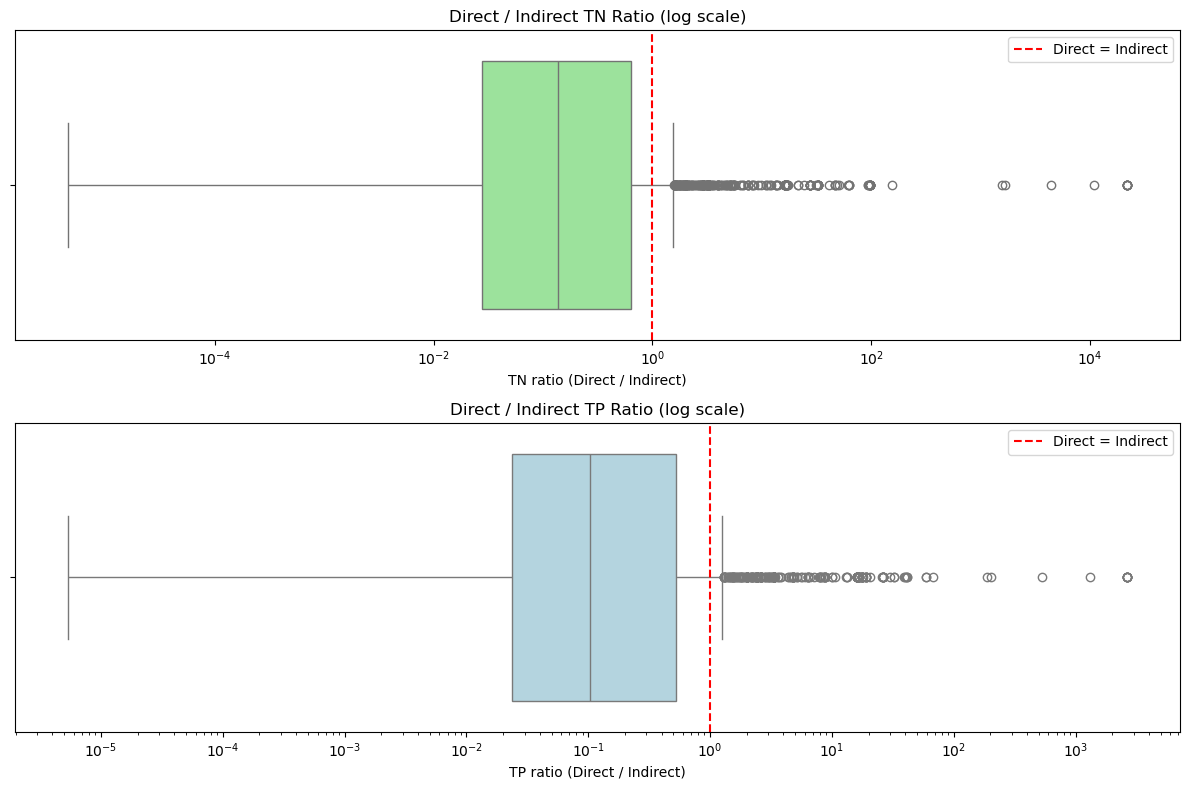

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Compute ratios ---
Total_avg_23['TN_ratio'] = (
    Total_avg_23['CoastalWatershedDirectTN_avg_grm2yr'] /
    Total_avg_23['TotalIndirectCW_TN_grm2yr']
)
Total_avg_23['TP_ratio'] = (
    Total_avg_23['CoastalWatershedDirectTP_avg_grm2yr'] /
    Total_avg_23['TotalIndirectCW_TP_grm2yr']
)

# --- Set up figure (2 rows, 1 col) ---
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# TN ratio (horizontal boxplot)
sns.boxplot(x=Total_avg_23['TN_ratio'], ax=axs[0], color="lightgreen", orient="h")
axs[0].set_title("Direct / Indirect TN Ratio (log scale)")
axs[0].set_xlabel("TN ratio (Direct / Indirect)")
axs[0].set_xscale("log")
axs[0].axvline(1, color="red", linestyle="--", linewidth=1.5, label="Direct = Indirect")
axs[0].legend()

# TP ratio (horizontal boxplot)
sns.boxplot(x=Total_avg_23['TP_ratio'], ax=axs[1], color="lightblue", orient="h")
axs[1].set_title("Direct / Indirect TP Ratio (log scale)")
axs[1].set_xlabel("TP ratio (Direct / Indirect)")
axs[1].set_xscale("log")
axs[1].axvline(1, color="red", linestyle="--", linewidth=1.5, label="Direct = Indirect")
axs[1].legend()
plt.savefig(os.path.join(out_dir_fig, "Direct_Indirect_TN_TP_Ratios_Boxplots.png"), dpi=300)
plt.tight_layout()
plt.show()

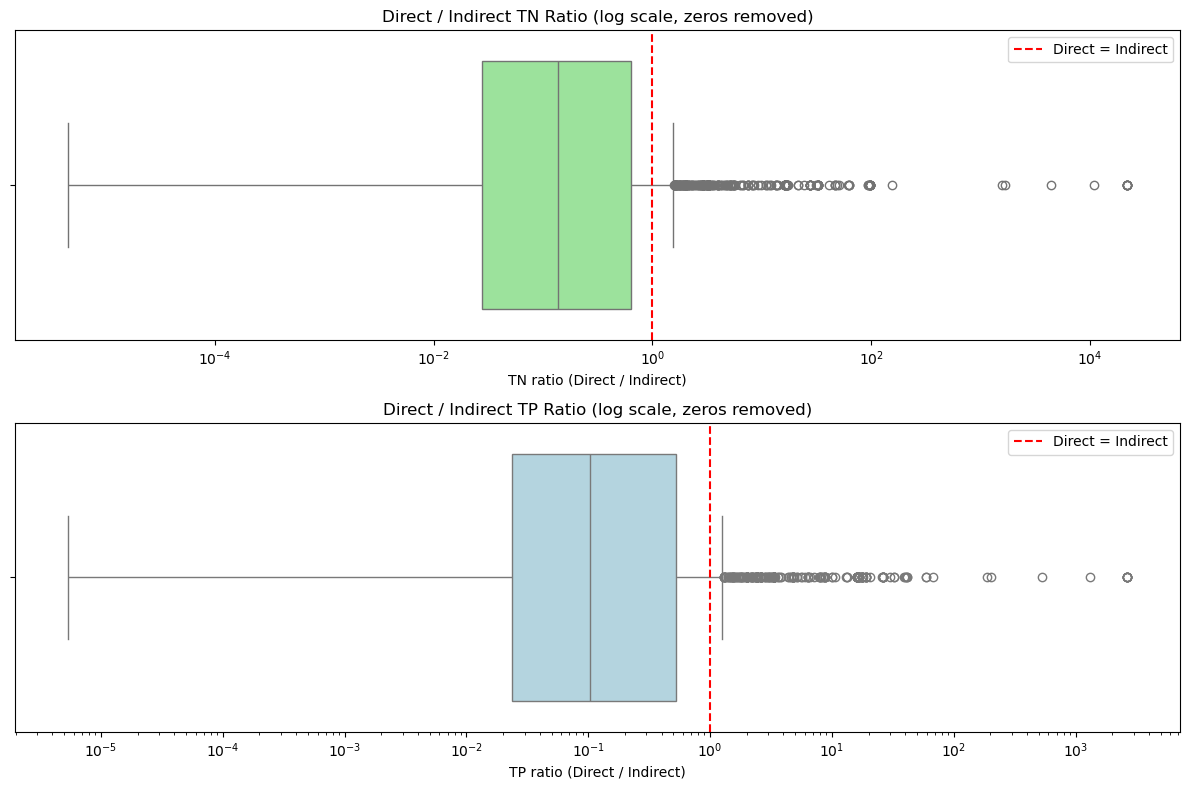

In [18]:
# --- Filter out rows where indirect TN or TP = 0 ---
filtered = Total_avg_23[
    (Total_avg_23['TotalIndirectCW_TN_grm2yr'] > 0) &
    (Total_avg_23['TotalIndirectCW_TP_grm2yr'] > 0)
].copy()

# --- Compute ratios after filtering ---
filtered['TN_ratio'] = (
    filtered['CoastalWatershedDirectTN_avg_grm2yr'] /
    filtered['TotalIndirectCW_TN_grm2yr']
)
filtered['TP_ratio'] = (
    filtered['CoastalWatershedDirectTP_avg_grm2yr'] /
    filtered['TotalIndirectCW_TP_grm2yr']
)

# --- Set up figure (2 rows, 1 col) ---
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# TN ratio
sns.boxplot(x=filtered['TN_ratio'], ax=axs[0], color="lightgreen", orient="h")
axs[0].set_title("Direct / Indirect TN Ratio (log scale, zeros removed)")
axs[0].set_xlabel("TN ratio (Direct / Indirect)")
axs[0].set_xscale("log")
axs[0].axvline(1, color="red", linestyle="--", linewidth=1.5, label="Direct = Indirect")
axs[0].legend()

# TP ratio
sns.boxplot(x=filtered['TP_ratio'], ax=axs[1], color="lightblue", orient="h")
axs[1].set_title("Direct / Indirect TP Ratio (log scale, zeros removed)")
axs[1].set_xlabel("TP ratio (Direct / Indirect)")
axs[1].set_xscale("log")
axs[1].axvline(1, color="red", linestyle="--", linewidth=1.5, label="Direct = Indirect")
axs[1].legend()
plt.savefig(os.path.join(out_dir_fig, "TN_TP_Ratios_Filtered.png"), dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

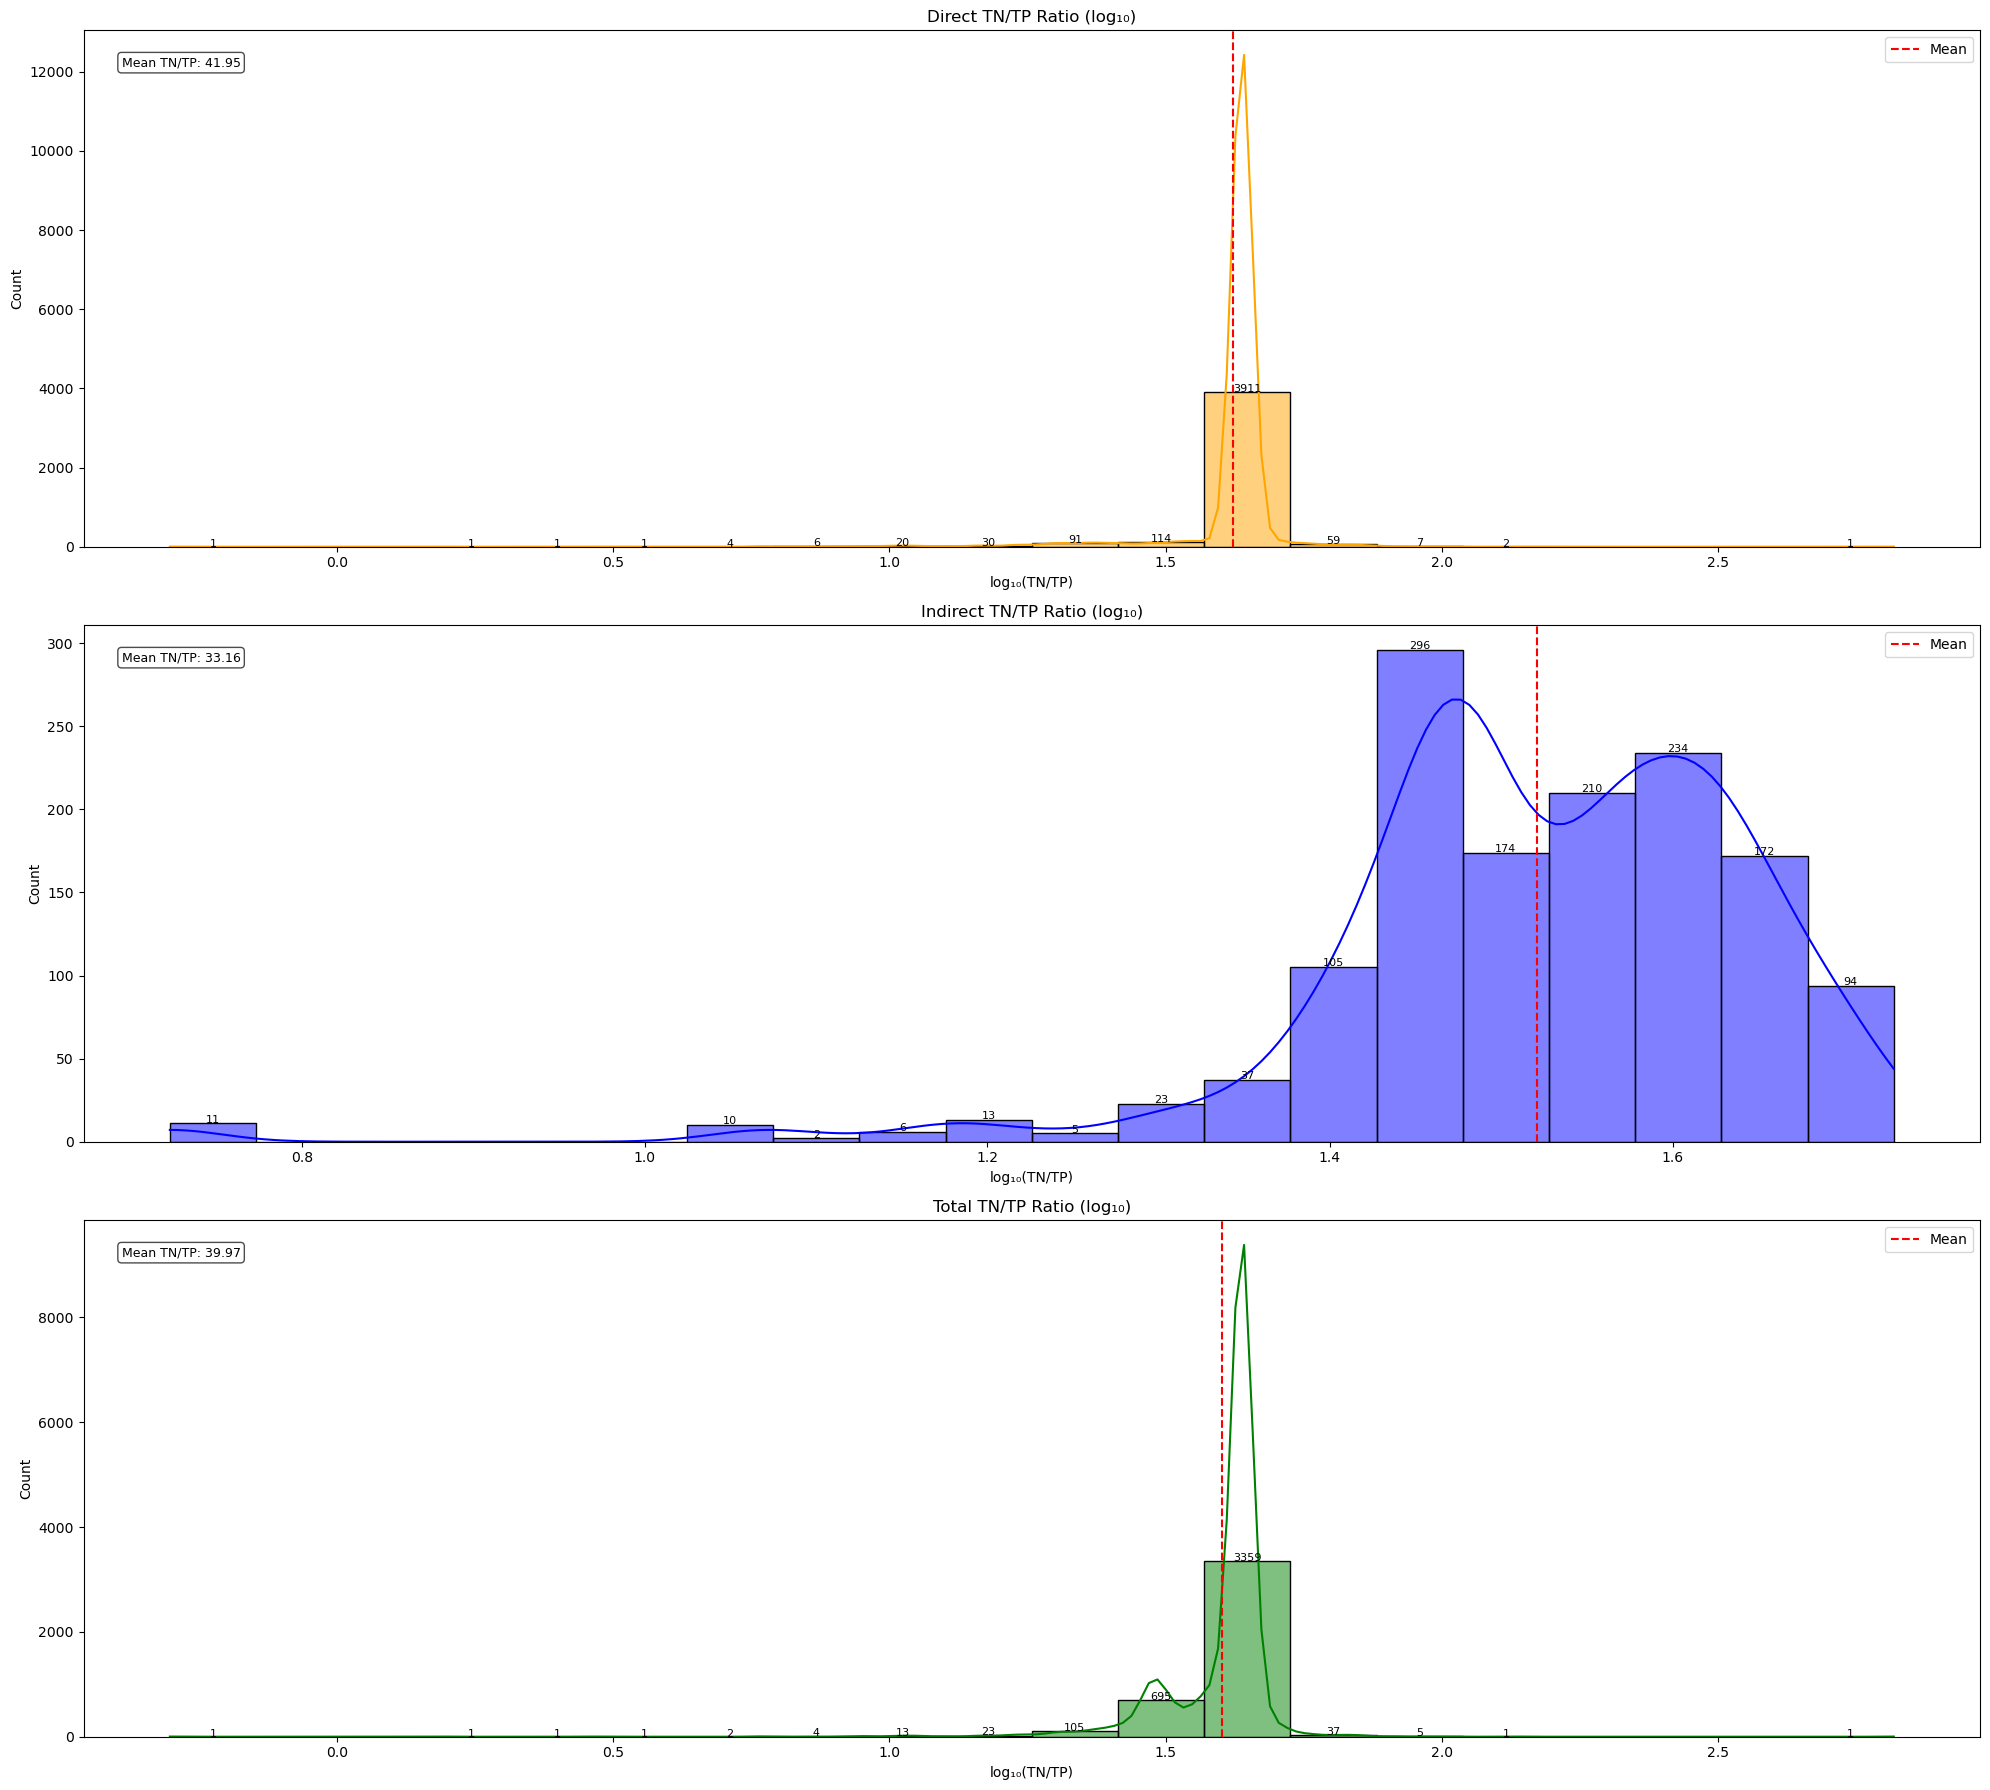

In [27]:

def safe_log10(series):
    return np.log10(series.replace(0, np.nan))

Total_avg_23['log10_Direct_TN'] = safe_log10(Total_avg_23['CoastalWatershedDirectTN_avg_grm2yr'])
Total_avg_23['log10_Indirect_TN'] = safe_log10(Total_avg_23['TotalIndirectCW_TN_grm2yr'])
Total_avg_23['log10_Annual_N'] = safe_log10(Total_avg_23['TotalN_avg_grm2yr'])

Total_avg_23['log10_Direct_TP'] = safe_log10(Total_avg_23['CoastalWatershedDirectTP_avg_grm2yr'])
Total_avg_23['log10_Indirect_TP'] = safe_log10(Total_avg_23['TotalIndirectCW_TP_grm2yr'])
Total_avg_23['log10_Annual_P'] = safe_log10(Total_avg_23['TotalP_avg_grm2yr'])

Total_avg_23['Direct_TNTP_Ratio'] = Total_avg_23['CoastalWatershedDirectTN_avg_grm2yr'] / Total_avg_23['CoastalWatershedDirectTP_avg_grm2yr']
Total_avg_23['Indirect_TNTP_Ratio'] = Total_avg_23['TotalIndirectCW_TN_grm2yr'] / Total_avg_23['TotalIndirectCW_TP_grm2yr']
Total_avg_23['Total_TNTP_Ratio'] = Total_avg_23['TotalN_avg_grm2yr'] / Total_avg_23['TotalP_avg_grm2yr']

Total_avg_23['log10_Direct_TNTP'] = safe_log10(Total_avg_23['Direct_TNTP_Ratio'])
Total_avg_23['log10_Indirect_TNTP'] = safe_log10(Total_avg_23['Indirect_TNTP_Ratio'])
Total_avg_23['log10_Total_TNTP'] = safe_log10(Total_avg_23['Total_TNTP_Ratio'])


# Set up new figure for TN/TP ratios
fig, axs = plt.subplots(3, 1, figsize=(20, 18))

# Data and axis configuration
tn_tp_plot_info = [
    ('log10_Direct_TNTP', axs[0], 'Direct TN/TP Ratio (log₁₀)', 'orange'),
    ('log10_Indirect_TNTP', axs[1], 'Indirect TN/TP Ratio (log₁₀)', 'blue'),
    ('log10_Total_TNTP', axs[2], 'Total TN/TP Ratio (log₁₀)', 'green'),
]

# Plot TN/TP ratios
for col, ax, title, color in tn_tp_plot_info:
    sns.histplot(Total_avg_23[col], kde=True, ax=ax, color=color, bins=20)
    ax.axvline(Total_avg_23[col].mean(), color='red', linestyle='--', label='Mean')
    ax.set_title(title)
    ax.set_xlabel('log₁₀(TN/TP)')
    ax.set_ylabel('Count')

    # Annotate bin counts
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:
            x = patch.get_x() + patch.get_width() / 2
            ax.text(x, height + 0.5, int(height), ha='center', fontsize=8)

    # Add mean label
    mean_val = 10 ** Total_avg_23[col].mean()
    ax.text(0.02, 0.95, f"Mean TN/TP: {mean_val:.2f}", transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, "TN_TP_Ratios_Log10.png"), dpi=300)
plt.show()


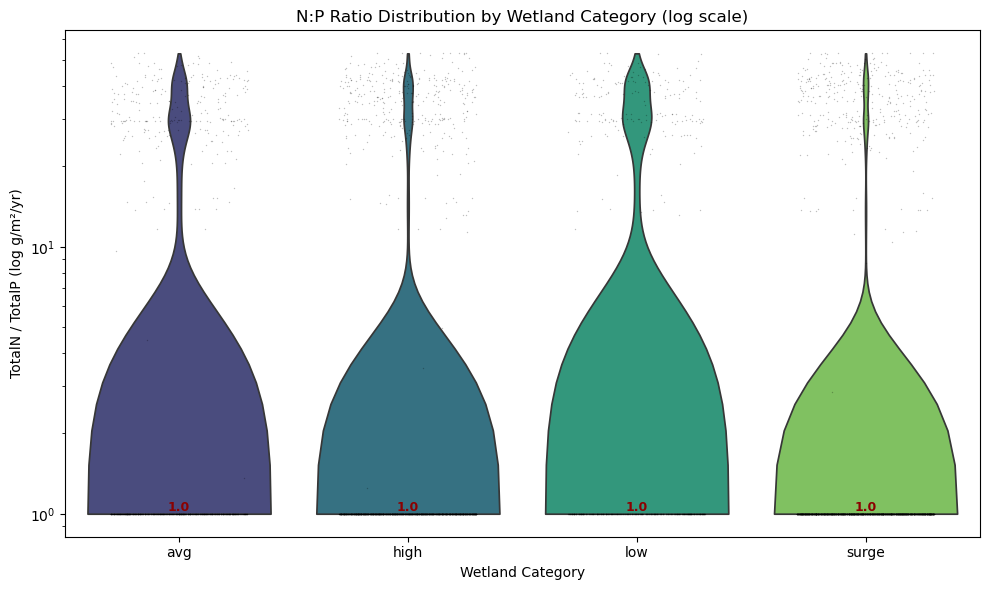

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# --- Build N:P ratio DataFrame ---
ratios = []
for category in categories:
    file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{category}_{year}.csv')
    df = pd.read_csv(file)
    df['N_to_P_ratio'] = df[f'TotalN_{category}_grm2yr'] / df[f'TotalP_{category}_grm2yr']
    df['Category'] = category
    ratios.append(df[['N_to_P_ratio', 'Category']])

# --- Combine all categories ---
ratio_df = pd.concat(ratios, ignore_index=True)

# --- Initialize plot ---
plt.figure(figsize=(10, 6))

# Violin plot (distribution)
sns.violinplot(
    data=ratio_df, x='Category', y='N_to_P_ratio', hue='Category',
    palette='viridis', legend=False, cut=0, density_norm='width', inner=None
)

# Swarmplot (individual points)
sns.stripplot(
    data=ratio_df, x='Category', y='N_to_P_ratio',
    color='black', size=1, jitter=0.3, alpha=0.25
)

# Log scale
plt.yscale('log')
plt.ylabel('TotalN / TotalP (log g/m²/yr)')
plt.xlabel('Wetland Category')
plt.title('N:P Ratio Distribution by Wetland Category (log scale)')

# Annotate medians
medians = ratio_df.groupby("Category")["N_to_P_ratio"].median()
for i, cat in enumerate(medians.index):
    plt.text(i, medians[cat], f'{medians[cat]:.1f}',
             ha='center', va='bottom', fontweight='bold', fontsize=9, color='darkred')

# Layout and save
plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"N_to_P_Ratio_BoxViolin_{year}.png"), dpi=300)
plt.show()


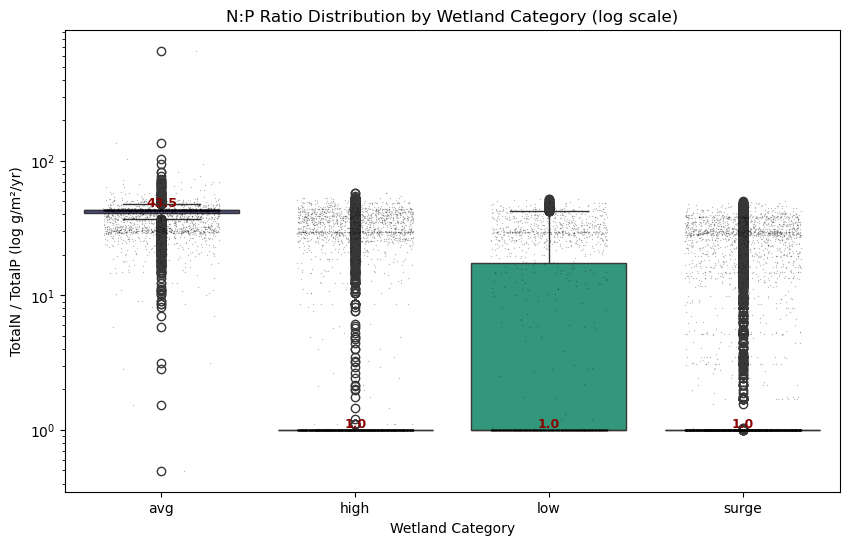

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# --- Build N:P ratio DataFrame ---
ratios = []
for category in categories:
    file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{category}_{year}.csv')
    df = pd.read_csv(file)
    df['N_to_P_ratio'] = df[f'TotalN_{category}_grm2yr'] / df[f'TotalP_{category}_grm2yr']
    df['Category'] = category
    ratios.append(df[['N_to_P_ratio', 'Category']])

# --- Combine all categories ---
ratio_df = pd.concat(ratios, ignore_index=True)
ratio_df = ratio_df[ratio_df['N_to_P_ratio'] > 0]  # Avoid log errors

# --- Initialize plot ---
plt.figure(figsize=(10, 6))

# Boxplot (replacing violin plot)
sns.boxplot(
    data=ratio_df, x='Category', y='N_to_P_ratio',
    hue='Category', palette='viridis', legend=False
)

# Optional: Swarmplot for individual points
sns.stripplot(
    data=ratio_df, x='Category', y='N_to_P_ratio',
    color='black', size=1, jitter=0.3, alpha=0.25
)

# Log scale
plt.yscale('log')
plt.ylabel('TotalN / TotalP (log g/m²/yr)')
plt.xlabel('Wetland Category')
plt.title('N:P Ratio Distribution by Wetland Category (log scale)')

# Annotate medians
medians = ratio_df.groupby("Category")["N_to_P_ratio"].median()
for i, cat in enumerate(medians.index):
    plt.text(i, medians[cat], f'{medians[cat]:.1f}',
             ha='center', va='bottom', fontweight='bold', fontsize=9, color='darkred')


## Plot Direct loads

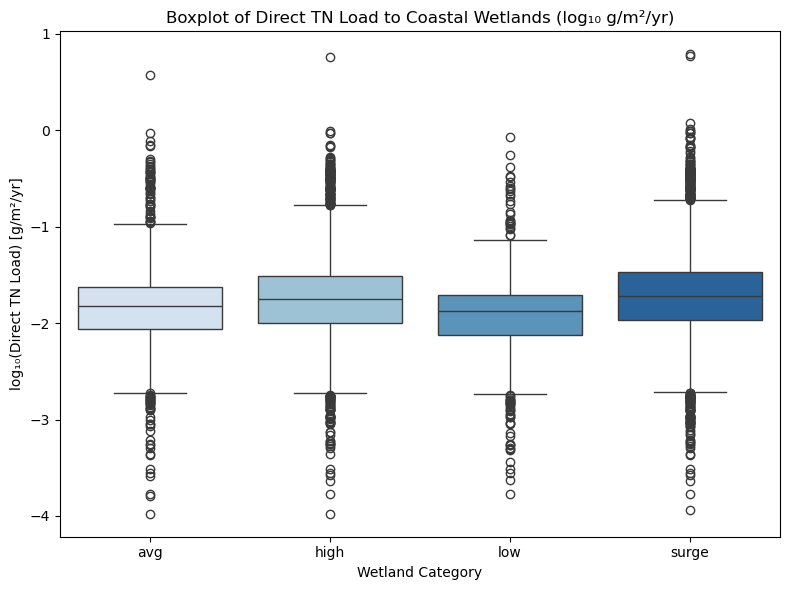

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Define categories and year
categories = ["avg", "high", "low", "surge"]
year = 23
long_data = []

# Build long-format DataFrame using Direct TN
for cat in categories:
    df = globals()[f"Total_{cat}_{year}"]
    tn_col = f"CoastalWatershedDirectTN_{cat}_grm2yr"
    
    subset = pd.DataFrame({
        "Category": cat,
        "DirectTN": df[tn_col]
    })
    long_data.append(subset)

# Combine and log-transform
long_df = pd.concat(long_data, ignore_index=True)
long_df = long_df[long_df['DirectTN'] > 0]
long_df['log10_DirectTN'] = np.log10(long_df['DirectTN'])

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=long_df,
    x="Category",
    y="log10_DirectTN",
    hue="Category",      # Fixes the warning
    palette="Blues",
    legend=False         # Prevents duplicate legend
)
plt.title("Boxplot of Direct TN Load to Coastal Wetlands (log₁₀ g/m²/yr)")
plt.ylabel("log₁₀(Direct TN Load) [g/m²/yr]")
plt.xlabel("Wetland Category")
plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"Boxplot_DirectTN_log10_{year}.jpeg"), dpi=300)
plt.show()


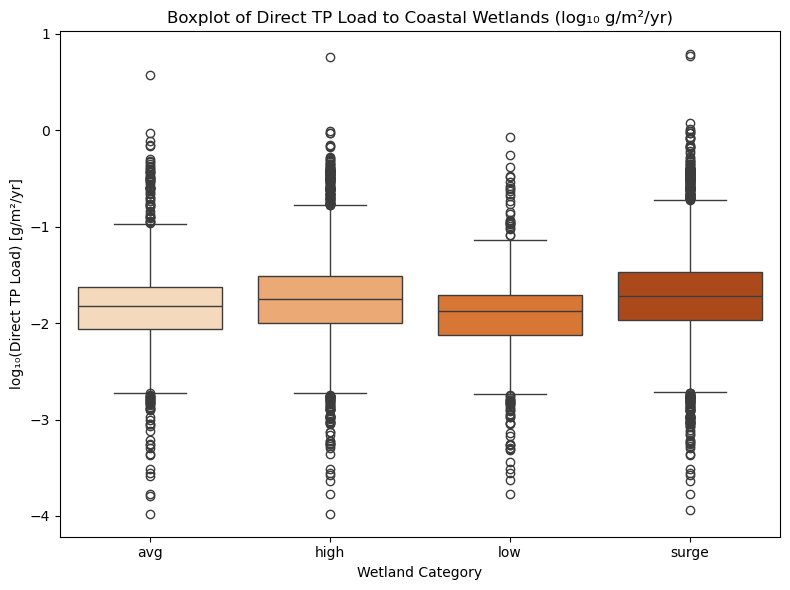

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Define categories and year
categories = ["avg", "high", "low", "surge"]
year = 23
long_data_tp = []

# Build long-format DataFrame using Direct TP
for cat in categories:
    df = globals()[f"Total_{cat}_{year}"]
    tp_col = f"CoastalWatershedDirectTP_{cat}_grm2yr"
    
    subset = pd.DataFrame({
        "Category": cat,
        "DirectTP": df[tp_col]
    })
    long_data_tp.append(subset)

# Combine and log-transform
long_df_tp = pd.concat(long_data_tp, ignore_index=True)
long_df_tp = long_df_tp[long_df_tp['DirectTP'] > 0]
long_df_tp['log10_DirectTP'] = np.log10(long_df_tp['DirectTP'])

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=long_df_tp,
    x="Category",
    y="log10_DirectTP",
    hue="Category",      # Fixes the FutureWarning
    palette="Oranges",
    legend=False         # Avoid duplicate legend
)
plt.title("Boxplot of Direct TP Load to Coastal Wetlands (log₁₀ g/m²/yr)")
plt.ylabel("log₁₀(Direct TP Load) [g/m²/yr]")
plt.xlabel("Wetland Category")
plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"Boxplot_DirectTP_log10_{year}.jpeg"), dpi=300)
plt.show()


## plot to compare differnt inundatios

In [11]:
import pandas as pd

# Create list of categories and year
categories = ["avg", "high", "low", "surge"]
year = 23

# Collect data
long_data = []

for cat in categories:
    df_name = f"Total_{cat}_{year}"
    df = globals()[df_name]
    
    # Extract TN and TP values and attach category label
    tn_col = f"TotalN_{cat}_grm2yr"
    tp_col = f"TotalP_{cat}_grm2yr"
    
    subset = pd.DataFrame({
        "Category": cat,
        "TotalN": df[tn_col],
        "TotalP": df[tp_col]
    })
    
    long_data.append(subset)

# Concatenate into long_df
long_df = pd.concat(long_data, ignore_index=True)


In [15]:
Total_avg_23.columns

Index(['CW_Id', 'CoastalWatershedDirectTN_avg_grm2yr',
       'CoastalWatershedDirectTP_avg_grm2yr', 'TotalIndirectCW_TN_grm2yr',
       'TotalIndirectCW_TP_grm2yr', 'TotalN_avg_grm2yr', 'TotalP_avg_grm2yr',
       'Wetland', 'group_ids', 'Category'],
      dtype='object')

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter non-positive values to avoid log errors
long_df = long_df[long_df['TotalN'] > 0]

plt.figure(figsize=(8, 6))
sns.violinplot(
    data=long_df,
    x="Category",
    y="TotalN",
    hue="Category",         # Set hue to match x
    palette="Blues",
    cut=0,
    linewidth=1,
    inner="box",
    legend=False            # Suppress duplicate legend
)
plt.yscale("log")
plt.title("Total Nitrogen Load to coastal wetlands with different inundation levels (g/m²/yr)")
plt.ylabel("TotalN (log g/m²/yr)")
plt.xlabel("Wetland Category")
plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"TotalN_violinplot_categorycomparison_{year}.png"), dpi=300)
plt.show()


KeyError: 'TotalN'

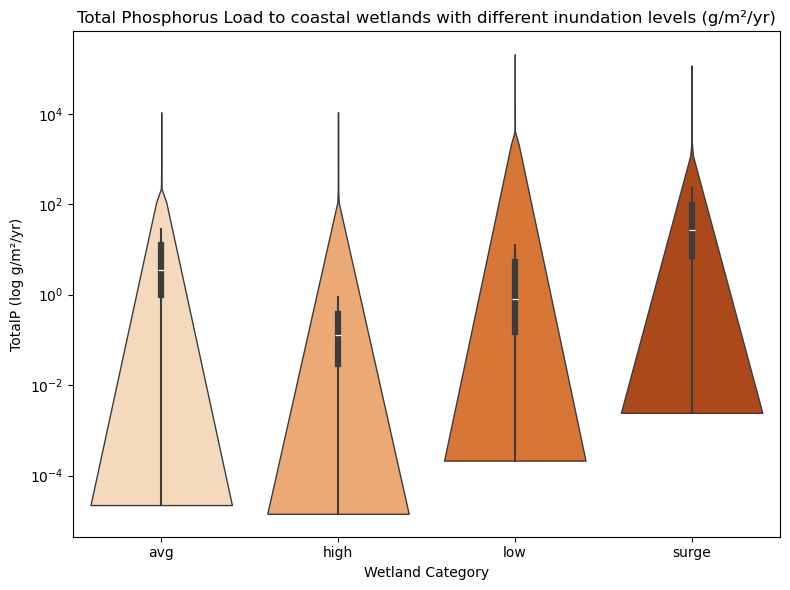

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter non-positive values to avoid log errors
long_df = long_df[long_df['TotalP'] > 0]

plt.figure(figsize=(8, 6))
sns.violinplot(
    data=long_df,
    x="Category",
    y="TotalP",
    hue="Category",         # Set hue to match x
    palette="Oranges",
    cut=0,
    linewidth=1,
    inner="box",
    legend=False            # Suppress duplicate legend
)
plt.yscale("log")
plt.title("Total Phosphorus Load to coastal wetlands with different inundation levels (g/m²/yr)")
plt.ylabel("TotalP (log g/m²/yr)")
plt.xlabel("Wetland Category")
plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"TotalP_violinplot_categorycomparison_{year}.png"), dpi=300)
plt.show()


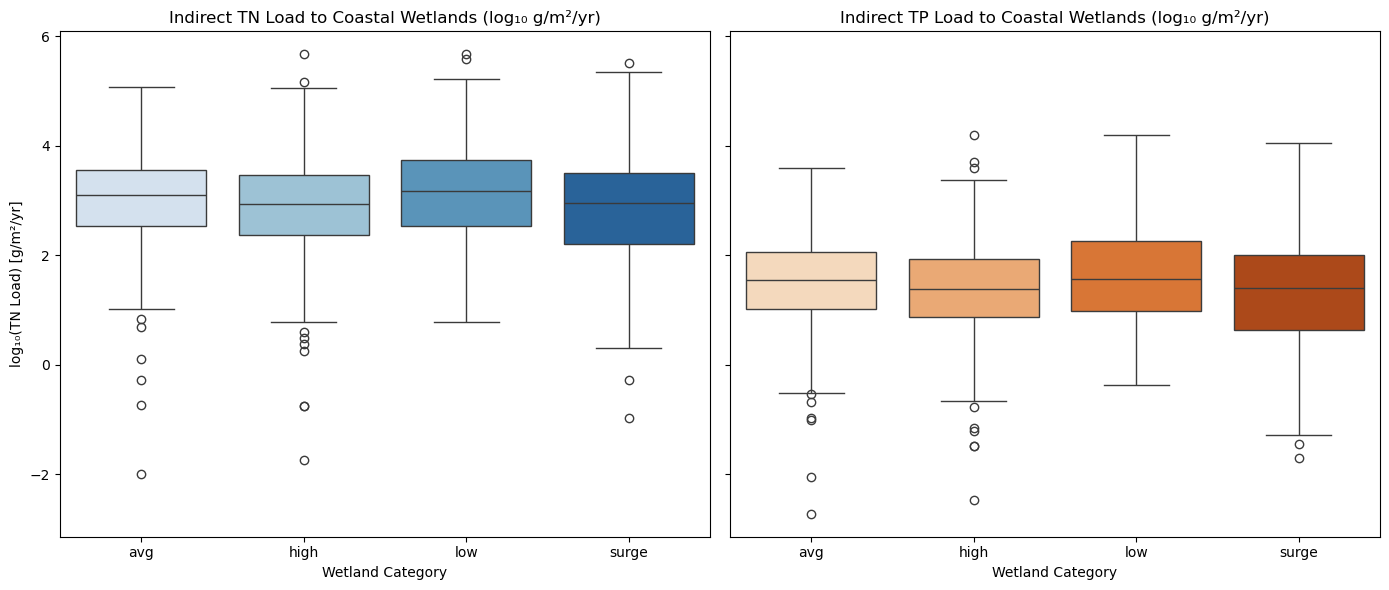

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Categories and year
categories = ["avg", "high", "low", "surge"]
year = 23

# ---- INDIRECT TN ----
long_data_tn = []
for cat in categories:
    df = globals()[f"Total_{cat}_{year}"]
    tn_col = "TotalIndirectCW_TN_grm2yr"
    subset = pd.DataFrame({
        "Category": cat,
        "IndirectTN": df[tn_col]
    })
    long_data_tn.append(subset)

long_df_tn = pd.concat(long_data_tn, ignore_index=True)
long_df_tn = long_df_tn[long_df_tn['IndirectTN'] > 0]
long_df_tn['log10_IndirectTN'] = np.log10(long_df_tn['IndirectTN'])

# ---- INDIRECT TP ----
long_data_tp = []
for cat in categories:
    df = globals()[f"Total_{cat}_{year}"]
    tp_col = "TotalIndirectCW_TP_grm2yr"
    subset = pd.DataFrame({
        "Category": cat,
        "IndirectTP": df[tp_col]
    })
    long_data_tp.append(subset)

long_df_tp = pd.concat(long_data_tp, ignore_index=True)
long_df_tp = long_df_tp[long_df_tp['IndirectTP'] > 0]
long_df_tp['log10_IndirectTP'] = np.log10(long_df_tp['IndirectTP'])

# ---- PLOTTING ----
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Boxplot for TN
sns.boxplot(
    data=long_df_tn,
    x="Category",
    y="log10_IndirectTN",
    hue="Category",
    palette="Blues",
    legend=False,
    ax=axs[0]
)
axs[0].set_title("Indirect TN Load to Coastal Wetlands (log₁₀ g/m²/yr)")
axs[0].set_ylabel("log₁₀(TN Load) [g/m²/yr]")
axs[0].set_xlabel("Wetland Category")

# Boxplot for TP
sns.boxplot(
    data=long_df_tp,
    x="Category",
    y="log10_IndirectTP",
    hue="Category",
    palette="Oranges",
    legend=False,
    ax=axs[1]
)
axs[1].set_title("Indirect TP Load to Coastal Wetlands (log₁₀ g/m²/yr)")
axs[1].set_ylabel("")  # Empty for cleaner layout
axs[1].set_xlabel("Wetland Category")

plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"Boxplot_IndirectTN_TP_log10_{year}.png"), dpi=300)
plt.show()
